# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


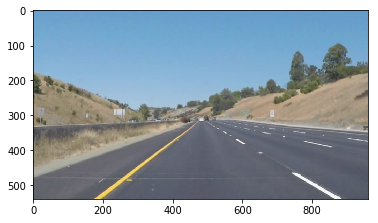

In [44]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print('slope is ',((y2-y1)/(x2-x1)))
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

In [ ]:
blur_gray = gaussian_blur(gray, 5)
plt.imshow(blur_gray)

In [ ]:
edges = canny(blur_gray, 10, 180)
plt.imshow(edges)

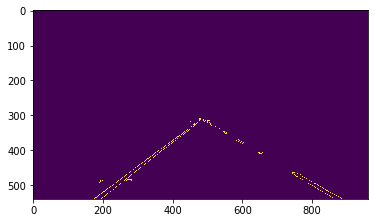

In [62]:
# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(60,imshape[0]),(480, 300), (480, 300), (imshape[1]-60,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges)

slope is  -0.748691099476
slope is  -0.781420765027
slope is  -0.752525252525
slope is  0.444444444444
slope is  -0.786163522013
slope is  0.6
slope is  0.571428571429
slope is  0.521739130435
slope is  -0.752136752137
slope is  0.769230769231
slope is  0.5
slope is  0.582417582418
slope is  -0.740740740741
slope is  0.581395348837
slope is  -0.828125
slope is  0.552631578947
slope is  0.611111111111
slope is  0.0
slope is  0.6
slope is  0.142857142857
slope is  -3.0
slope is  -0.809523809524
slope is  -5.0
slope is  0.625
slope is  0.666666666667
slope is  0.5
slope is  0.578947368421
slope is  0.75
slope is  0.5
slope is  0.666666666667
slope is  0.7
slope is  -1.2
slope is  -1.0
slope is  -0.9
slope is  0.5
slope is  1.5
slope is  0.0909090909091
slope is  0.5
slope is  0.166666666667
slope is  0.25
slope is  0.0
slope is  -1.375
slope is  0.0
slope is  -0.833333333333
slope is  0.5
slope is  -1.4
slope is  -0.714285714286
slope is  0.545454545455
slope is  0.0
slope is  0.571428571

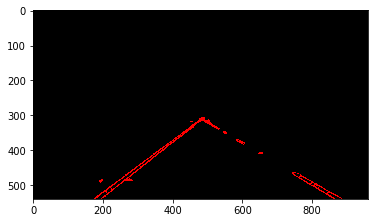

In [63]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 3
min_line_length = 3
max_line_gap = 7
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(lines)

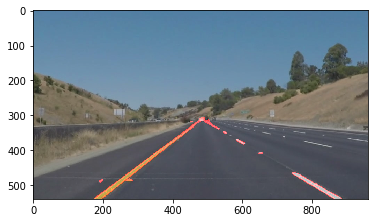

In [64]:
mix = weighted_img(lines, image, α=0.8, β=1., λ=0.)
plt.imshow(mix)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [65]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 10, 180)
    imshape = image.shape
    vertices = np.array([[(60,imshape[0]),(480, 300), (480, 300), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi/180
    threshold = 3
    min_line_length = 3
    max_line_gap = 7
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

slope is  0.602564102564
slope is  0.611940298507
slope is  -0.725663716814
slope is  0.626943005181
slope is  -0.714285714286
slope is  -0.75
slope is  -0.771428571429
slope is  0.583333333333
slope is  -0.818181818182
slope is  0.621951219512
slope is  -0.723214285714
slope is  -0.5
slope is  0.628571428571
slope is  0.614035087719
slope is  -0.833333333333
slope is  0.61038961039
slope is  -0.789473684211
slope is  0.605263157895
slope is  -0.733333333333
slope is  -0.882352941176
slope is  -0.777777777778
slope is  0.607142857143
slope is  0.583333333333
slope is  0.6
slope is  -0.166666666667
slope is  -0.75
slope is  2.66666666667
slope is  -1.0
slope is  -0.111111111111
slope is  -0.285714285714
slope is  -0.733333333333
slope is  -0.75
slope is  -0.428571428571
slope is  -0.833333333333
slope is  0.0
slope is  -0.125
slope is  0.25
slope is  0.588235294118
slope is  -0.1
slope is  -0.166666666667
slope is  0.0833333333333
slope is  0.25
slope is  4.0
slope is  -0.5
slope is  -0

  0%|          | 0/222 [00:00<?, ?it/s]

slope is  0.602564102564
slope is  0.611940298507
slope is  -0.725663716814
slope is  0.626943005181
slope is  -0.714285714286
slope is  -0.75
slope is  -0.771428571429
slope is  0.583333333333
slope is  -0.818181818182
slope is  0.621951219512
slope is  -0.723214285714
slope is  -0.5
slope is  0.628571428571
slope is  0.614035087719
slope is  -0.833333333333
slope is  0.61038961039
slope is  -0.789473684211
slope is  0.605263157895
slope is  -0.733333333333
slope is  -0.882352941176
slope is  -0.777777777778
slope is  0.607142857143
slope is  0.583333333333
slope is  0.6
slope is  -0.166666666667
slope is  -0.75
slope is  2.66666666667
slope is  -1.0
slope is  -0.111111111111
slope is  -0.285714285714
slope is  -0.733333333333
slope is  -0.75
slope is  -0.428571428571
slope is  -0.833333333333
slope is  0.0
slope is  -0.125
slope is  0.25
slope is  0.588235294118
slope is  -0.1
slope is  -0.166666666667
slope is  0.0833333333333
slope is  0.25
slope is  4.0
slope is  -0.5
slope is  -0

  1%|▏         | 3/222 [00:00<00:23,  9.24it/s]


slope is  0.647058823529
slope is  -0.875
slope is  0.555555555556
slope is  -0.636363636364
slope is  0.142857142857
slope is  -0.684210526316
slope is  0.625
slope is  0.0
slope is  -0.758620689655
slope is  0.4
slope is  -1.0
slope is  -1.0
slope is  -0.752941176471
slope is  -0.538461538462
slope is  0.666666666667
slope is  -1.1
slope is  0.142857142857
slope is  -0.666666666667
slope is  0.55
slope is  0.634146341463
slope is  0.25
slope is  3.0
slope is  0.5
slope is  -0.647058823529
slope is  0.8
slope is  -1.5
slope is  -1.2
slope is  -0.5
slope is  -0.5
slope is  -0.5
slope is  -2.0
slope is  2.0
slope is  -1.8
slope is  0.4
slope is  0.566037735849
slope is  -0.3
slope is  -4.0
slope is  -1.33333333333
slope is  -0.5
slope is  0.0
slope is  -1.5
slope is  -0.333333333333
slope is  0.833333333333
slope is  -1.5
slope is  0.75
slope is  0.538461538462
slope is  0.0
slope is  3.0
slope is  -0.75
slope is  0.62962962963
slope is  0.0
slope is  -3.5
slope is  0.5
slope is  -inf


  3%|▎         | 6/222 [00:00<00:38,  5.58it/s]


slope is  -0.8
slope is  -0.2
slope is  0.5
slope is  -0.833333333333
slope is  -1.0
slope is  -0.5
slope is  -0.684210526316
slope is  -1.4
slope is  0.666666666667
slope is  0.624505928854
slope is  1.0
slope is  -0.833333333333
slope is  0.5
slope is  5.0
slope is  -0.666666666667
slope is  0.25
slope is  -inf
slope is  0.639344262295
slope is  -8.0
slope is  0.666666666667
slope is  0.375
slope is  0.6
slope is  0.857142857143
slope is  1.0
slope is  -0.5
slope is  -1.0
slope is  -0.75
slope is  -0.857142857143
slope is  0.628099173554
slope is  0.605263157895
slope is  -0.714285714286
slope is  0.6
slope is  0.584905660377
slope is  0.6875
slope is  -0.833333333333
slope is  -0.333333333333
slope is  0.545454545455
slope is  -0.75
slope is  -1.13333333333
slope is  0.591836734694
slope is  0.4
slope is  -0.625
slope is  -0.25
slope is  0.555555555556
slope is  -inf
slope is  0.541666666667
slope is  0.0
slope is  -0.72
slope is  0.55
slope is  -0.695652173913
slope is  -1.0
slope

  3%|▎         | 7/222 [00:01<00:42,  5.12it/s]

slope is  -0.714285714286
slope is  -0.2
slope is  -0.416666666667
slope is  -0.833333333333
slope is  -0.583333333333
slope is  -0.777777777778
slope is  -0.75
slope is  -0.755555555556
slope is  -1.0
slope is  -0.714285714286
slope is  0.610169491525
slope is  -0.9
slope is  0.666666666667
slope is  -0.333333333333
slope is  -0.571428571429
slope is  1.5
slope is  -0.454545454545
slope is  -1.0
slope is  0.615384615385
slope is  -0.9375
slope is  0.620437956204
slope is  -1.0
slope is  0.333333333333
slope is  1.5
slope is  1.0
slope is  0.612244897959
slope is  -1.0
slope is  -1.15789473684
slope is  -1.25
slope is  -1.0
slope is  -1.0
slope is  0.590909090909
slope is  0.727272727273
slope is  0.8
slope is  0.61038961039
slope is  -5.0
slope is  -0.428571428571
slope is  -0.8
slope is  0.636363636364
slope is  -0.833333333333
slope is  0.0
slope is  -3.0
slope is  1.0
slope is  -0.6
slope is  0.5
slope is  -0.75
slope is  -0.625
slope is  -9.0
slope is  0.833333333333
slope is  -0.

  5%|▍         | 10/222 [00:01<00:34,  6.20it/s]

slope is  -4.0
slope is  0.684210526316
slope is  -0.8
slope is  0.818181818182
slope is  1.0
slope is  0.25
slope is  0.777777777778
slope is  0.875
slope is  0.571428571429
slope is  -1.33333333333
slope is  -inf
slope is  1.0
slope is  0.0
slope is  0.714285714286
slope is  4.5
slope is  0.666666666667
slope is  -0.666666666667
slope is  0.714285714286
slope is  0.333333333333
slope is  0.25
slope is  9.0
slope is  -0.666666666667
slope is  -inf
slope is  0.666666666667
slope is  0.75
slope is  0.444444444444
slope is  -0.75
slope is  2.5
slope is  -1.33333333333
slope is  3.0
slope is  -0.333333333333
slope is  0.8
slope is  -0.8
slope is  -1.33333333333
slope is  0.4
slope is  -1.5
slope is  -0.75
slope is  -3.5
slope is  -0.666666666667
slope is  0.7
slope is  0.0
slope is  -3.0
slope is  -1.28571428571
slope is  0.666666666667
slope is  5.0
slope is  0.333333333333
slope is  0.75
slope is  0.6
slope is  0.5
slope is  0.727272727273
slope is  0.125
slope is  0.125
slope is  -2.0


  5%|▍         | 11/222 [00:01<00:33,  6.33it/s]

 -0.833333333333
slope is  0.666666666667
slope is  0.677419354839
slope is  0.75
slope is  0.4
slope is  -0.5
slope is  4.0
slope is  0.363636363636
slope is  0.375
slope is  -1.5
slope is  0.649122807018
slope is  0.25
slope is  -1.75
slope is  -0.444444444444
slope is  0.640625
slope is  0.727272727273
slope is  1.33333333333
slope is  -0.666666666667
slope is  4.5
slope is  inf
slope is  -1.75
slope is  0.2
slope is  0.8
slope is  0.0
slope is  0.727272727273
slope is  1.0
slope is  0.583333333333
slope is  -0.875
slope is  -0.285714285714
slope is  0.285714285714
slope is  -3.33333333333
slope is  0.5
slope is  0.5
slope is  0.75
slope is  -1.11111111111
slope is  -1.66666666667
slope is  -0.166666666667
slope is  -1.0
slope is  -1.44444444444
slope is  -3.0
slope is  0.666666666667
slope is  -0.25
slope is  -0.666666666667
slope is  2.0
slope is  0.0
slope is  -8.0
slope is  -0.566666666667
slope is  -1.0
slope is  0.620689655172
slope is  0.6875
slope is  0.5
slope is  0.7272727

  6%|▌         | 13/222 [00:02<00:46,  4.47it/s]

0.75
slope is  -9.0
slope is  -5.0
slope is  -1.33333333333
slope is  -3.0
slope is  1.33333333333
slope is  0.75
slope is  0.583333333333
slope is  -0.428571428571
slope is  1.3
slope is  0.0
slope is  -0.846153846154
slope is  -1.5
slope is  1.25
slope is  0.125
slope is  -0.333333333333
slope is  1.28571428571
slope is  -0.111111111111
slope is  0.833333333333
slope is  0.333333333333
slope is  0.4
slope is  0.5625
slope is  0.666666666667
slope is  0.0
slope is  0.333333333333
slope is  -0.4
slope is  0.0
slope is  0.5
slope is  -0.765625
slope is  0.65
slope is  0.666666666667
slope is  -0.888888888889
slope is  1.0
slope is  1.75
slope is  0.5
slope is  0.5
slope is  -0.25
slope is  0.2
slope is  -0.25
slope is  0.0
slope is  0.166666666667
slope is  0.666666666667
slope is  -0.846153846154
slope is  0.5
slope is  -1.0
slope is  -0.333333333333
slope is  -1.33333333333
slope is  -inf
slope is  0.333333333333
slope is  0.5
slope is  -1.33333333333
slope is  -0.333333333333
slope i

  7%|▋         | 16/222 [00:02<00:37,  5.56it/s]

 0.62962962963
slope is  -1.0
slope is  -1.0
slope is  0.0
slope is  -0.4
slope is  0.625
slope is  0.632352941176
slope is  0.5
slope is  0.785714285714
slope is  -1.05263157895
slope is  0.333333333333
slope is  0.5
slope is  2.0
slope is  0.0909090909091
slope is  0.5
slope is  -0.7
slope is  -0.5
slope is  0.5
slope is  -7.0
slope is  0.75
slope is  -1.66666666667
slope is  -1.0
slope is  0.5
slope is  -0.666666666667
slope is  -1.6
slope is  -0.333333333333
slope is  -2.0
slope is  -0.4
slope is  0.5
slope is  -4.0
slope is  0.125
slope is  -6.0
slope is  -1.0
slope is  0.111111111111
slope is  0.4
slope is  0.571428571429
slope is  -0.5
slope is  0.625
slope is  -0.166666666667
slope is  -0.333333333333
slope is  -0.428571428571
slope is  -1.25
slope is  0.727272727273
slope is  0.777777777778
slope is  -0.71186440678
slope is  6.0
slope is  0.590909090909
slope is  0.5
slope is  -1.0
slope is  -9.0
slope is  -1.5
slope is  0.642857142857
slope is  1.1
slope is  0.607142857143
sl

  8%|▊         | 18/222 [00:02<00:31,  6.45it/s]

 -1.33333333333
slope is  0.0
slope is  0.592592592593
slope is  -0.7
slope is  0.2
slope is  0.6
slope is  0.0
slope is  0.0
slope is  0.615384615385
slope is  -0.4
slope is  0.0
slope is  0.333333333333
slope is  0.62962962963
slope is  0.0
slope is  0.5
slope is  -0.666666666667
slope is  0.333333333333
slope is  0.25
slope is  -0.666666666667
slope is  4.0
slope is  0.666666666667
slope is  0.625
slope is  -1.1
slope is  -0.8
slope is  -0.6875
slope is  0.727272727273
slope is  -0.875
slope is  -0.666666666667
slope is  0.0
slope is  0.166666666667
slope is  -0.166666666667
slope is  0.6
slope is  0.62962962963
slope is  -0.727272727273
slope is  -1.0
slope is  0.5
slope is  -0.25
slope is  0.333333333333
slope is  0.6875
slope is  0.655629139073
slope is  0.624633431085
slope is  -0.857142857143
slope is  -0.634146341463
slope is  -0.645161290323
slope is  0.705882352941
slope is  -0.2
slope is  -0.769230769231
slope is  0.637931034483
slope is  -1.0
slope is  -0.555555555556
slop

  9%|▉         | 20/222 [00:02<00:27,  7.29it/s]

slope is  0.777777777778
slope is  0.5
slope is  0.428571428571
slope is  0.0
slope is  -0.5
slope is  0.5
slope is  0.777777777778
slope is  2.0
slope is  0.666666666667
slope is  -0.461538461538
slope is  1.66666666667
slope is  -5.0
slope is  -1.4
slope is  0.0
slope is  0.666666666667
slope is  0.75
slope is  0.64
slope is  0.714285714286
slope is  0.651851851852
slope is  0.65
slope is  0.624664879357
slope is  0.626865671642
slope is  -0.653846153846
slope is  -0.677419354839
slope is  -0.769230769231
slope is  0.657894736842
slope is  -0.8125
slope is  0.0909090909091
slope is  -0.875
slope is  -0.857142857143
slope is  -1.0
slope is  -0.606060606061
slope is  -1.33333333333
slope is  -0.75
slope is  -0.166666666667
slope is  0.333333333333
slope is  -0.545454545455
slope is  -0.666666666667
slope is  -0.666666666667
slope is  -0.666666666667
slope is  0.634615384615
slope is  0.5
slope is  -0.75
slope is  -1.0
slope is  -0.666666666667
slope is  -1.0
slope is  0.0
slope is  -1.

 11%|█         | 24/222 [00:03<00:21,  9.42it/s]

1.2
slope is  -0.4
slope is  -0.888888888889
slope is  -0.444444444444
slope is  -0.666666666667
slope is  0.714285714286
slope is  -2.0
slope is  -0.571428571429
slope is  -3.0
slope is  1.0
slope is  -0.666666666667
slope is  -0.142857142857
slope is  -1.0
slope is  1.66666666667
slope is  0.615384615385
slope is  -0.142857142857
slope is  3.0
slope is  1.4
slope is  0.0
slope is  -1.5
slope is  0.625
slope is  -0.68115942029
slope is  -0.363636363636
slope is  0.666666666667
slope is  0.707317073171
slope is  -0.755555555556
slope is  -0.731343283582
slope is  0.622950819672
slope is  0.625
slope is  0.606060606061
slope is  -0.734375
slope is  0.111111111111
slope is  0.636363636364
slope is  -0.25
slope is  -0.2
slope is  3.0
slope is  0.578947368421
slope is  0.875
slope is  0.619047619048
slope is  0.4
slope is  -0.7
slope is  0.6
slope is  -0.5
slope is  -0.666666666667
slope is  -0.25
slope is  0.682926829268
slope is  -0.666666666667
slope is  -0.375
slope is  0.0666666666667

 12%|█▏        | 26/222 [00:03<00:20,  9.40it/s]

1.0
slope is  0.620689655172
slope is  -0.631578947368
slope is  -0.2
slope is  -0.0833333333333
slope is  -0.111111111111
slope is  0.125
slope is  0.666666666667
slope is  -0.791666666667
slope is  0.208333333333
slope is  -0.676470588235
slope is  -8.0
slope is  -inf
slope is  0.4
slope is  -0.5
slope is  -0.125
slope is  -1.8
slope is  0.0
slope is  -0.166666666667
slope is  0.333333333333
slope is  1.5
slope is  1.0
slope is  -0.5
slope is  0.5
slope is  2.5
slope is  0.428571428571
slope is  0.575757575758
slope is  0.5
slope is  -0.5
slope is  0.428571428571
slope is  -0.5
slope is  0.5625
slope is  -0.25
slope is  0.5
slope is  -0.714285714286
slope is  0.714285714286
slope is  0.857142857143
slope is  -0.2
slope is  0.666666666667
slope is  -1.0
slope is  -1.0
slope is  -0.166666666667
slope is  3.5
slope is  0.181818181818
slope is  -0.2
slope is  0.0
slope is  0.9
slope is  -0.777777777778
slope is  0.5
slope is  0.222222222222
slope is  -1.2
slope is  -0.666666666667
slope 

 13%|█▎        | 29/222 [00:03<00:28,  6.74it/s]

 1.0
slope is  -0.142857142857
slope is  0.230769230769
slope is  -1.66666666667
slope is  0.565217391304
slope is  -0.166666666667
slope is  0.181818181818
slope is  -0.666666666667
slope is  -0.461538461538
slope is  -0.2
slope is  0.670588235294
slope is  -0.4
slope is  1.1
slope is  2.33333333333
slope is  -1.0
slope is  1.0
slope is  -1.5
slope is  -0.142857142857
slope is  -0.25
slope is  -0.707317073171
slope is  -0.294117647059
slope is  0.0
slope is  0.0
slope is  -inf
slope is  -0.75
slope is  -0.666666666667
slope is  2.25
slope is  0.307692307692
slope is  0.0
slope is  0.652173913043
slope is  0.0
slope is  -0.333333333333
slope is  -0.166666666667
slope is  0.0
slope is  0.25
slope is  -0.666666666667
slope is  -0.7
slope is  -1.5
slope is  -1.0
slope is  0.857142857143
slope is  0.333333333333
slope is  1.07692307692
slope is  -0.6
slope is  -0.333333333333
slope is  0.333333333333
slope is  -0.4
slope is  -0.875
slope is  0.0
slope is  -0.857142857143
slope is  0.125
sl

 14%|█▍        | 31/222 [00:04<00:27,  7.06it/s]

1.5
slope is  -0.25
slope is  -1.0
slope is  -1.0
slope is  1.75
slope is  -0.95652173913
slope is  -0.125
slope is  -0.428571428571
slope is  -0.166666666667
slope is  -0.166666666667
slope is  -1.57142857143
slope is  -0.875
slope is  -0.9
slope is  -0.8
slope is  -0.666666666667
slope is  0.622340425532
slope is  1.75
slope is  -3.0
slope is  -2.0
slope is  0.0
slope is  -0.25
slope is  -0.2
slope is  -0.2
slope is  -0.2
slope is  -0.2
slope is  1.5
slope is  -0.896551724138
slope is  1.0
slope is  -1.0
slope is  0.583333333333
slope is  -0.5
slope is  -1.0
slope is  -0.75
slope is  -0.166666666667
slope is  -0.666666666667
slope is  -0.25
slope is  -0.571428571429
slope is  -0.166666666667
slope is  -1.0
slope is  0.666666666667
slope is  -0.4
slope is  0.0
slope is  -0.4
slope is  6.0
slope is  -2.0
slope is  -0.333333333333
slope is  -1.16666666667
slope is  -0.25
slope is  -0.666666666667
slope is  1.5
slope is  -0.75
slope is  -1.5
slope is  -0.125
slope is  -0.25
slope is  -0.

 15%|█▍        | 33/222 [00:04<00:27,  6.97it/s]


slope is  -0.666666666667
slope is  -6.0
slope is  -1.5
slope is  0.666666666667
slope is  0.653846153846
slope is  1.0
slope is  -0.0714285714286
slope is  -1.0
slope is  0.628205128205
slope is  -0.666666666667
slope is  4.0
slope is  0.571428571429
slope is  0.714285714286
slope is  -0.714285714286
slope is  1.33333333333
slope is  0.192307692308
slope is  -0.363636363636
slope is  -1.3
slope is  -0.4
slope is  -1.5
slope is  -0.703703703704
slope is  -0.75
slope is  0.2
slope is  -0.428571428571
slope is  -0.444444444444
slope is  -3.0
slope is  -0.833333333333
slope is  -0.916666666667
slope is  0.641509433962
slope is  3.0
slope is  0.875
slope is  0.647058823529
slope is  0.653846153846
slope is  0.5
slope is  -0.8
slope is  0.6875
slope is  -inf
slope is  -0.166666666667
slope is  0.621212121212
slope is  0.625748502994
slope is  0.727272727273
slope is  -0.677419354839
slope is  0.635135135135
slope is  -0.666666666667
slope is  0.111111111111
slope is  0.634146341463
slope i

 15%|█▌        | 34/222 [00:04<00:31,  5.97it/s]

slope is  0.606060606061
slope is  -0.666666666667
slope is  -0.698113207547
slope is  0.648351648352
slope is  0.666666666667
slope is  -0.647058823529
slope is  0.685185185185
slope is  0.571428571429
slope is  0.6875
slope is  0.596153846154
slope is  0.666666666667
slope is  0.659090909091
slope is  -0.25
slope is  0.575757575758
slope is  0.5
slope is  -0.666666666667
slope is  -0.75
slope is  -0.727272727273
slope is  0.61038961039
slope is  -0.142857142857
slope is  -0.125
slope is  -1.66666666667
slope is  -0.666666666667
slope is  -0.1
slope is  -0.75
slope is  0.5
slope is  0.25
slope is  0.222222222222
slope is  -1.16666666667
slope is  -1.0
slope is  0.142857142857
slope is  0.4
slope is  0.5
slope is  -0.333333333333
slope is  -0.75
slope is  -4.0
slope is  -0.375
slope is  -0.727272727273
slope is  -0.642857142857
slope is  -0.25
slope is  0.695652173913
slope is  0.5625
slope is  0.333333333333
slope is  0.5
slope is  0.0
slope is  0.5
slope is  -0.615384615385
slope is 

 16%|█▌        | 36/222 [00:05<00:45,  4.07it/s]


slope is  1.22222222222
slope is  -1.0
slope is  -0.166666666667
slope is  1.0
slope is  0.75
slope is  -0.666666666667
slope is  -0.666666666667
slope is  0.333333333333
slope is  0.0
slope is  -0.75
slope is  0.181818181818
slope is  -0.428571428571
slope is  -0.375
slope is  1.11111111111
slope is  1.5
slope is  -0.125
slope is  -0.25
slope is  -0.428571428571
slope is  -0.428571428571
slope is  -0.333333333333
slope is  0.75
slope is  -1.0
slope is  -0.166666666667
slope is  0.666666666667
slope is  -0.2
slope is  -0.2
slope is  -2.0
slope is  -0.5
slope is  0.666666666667
slope is  1.75
slope is  0.555555555556
slope is  -0.125
slope is  0.555555555556
slope is  -0.571428571429
slope is  0.6875
slope is  -0.166666666667
slope is  -7.0
slope is  1.1
slope is  -0.333333333333
slope is  -8.0
slope is  0.636363636364
slope is  0.620689655172
slope is  0.1
slope is  0.666666666667
slope is  0.5
slope is  0.0
slope is  -1.25
slope is  0.0
slope is  2.33333333333
slope is  0.66666666666

 17%|█▋        | 38/222 [00:05<00:44,  4.14it/s]

-1.0
slope is  0.5625
slope is  -1.07692307692
slope is  -0.666666666667
slope is  0.333333333333
slope is  0.5
slope is  -0.333333333333
slope is  0.636363636364
slope is  0.666666666667
slope is  -0.666666666667
slope is  0.714285714286
slope is  0.25
slope is  -2.0
slope is  -0.166666666667
slope is  2.66666666667
slope is  -0.166666666667
slope is  -0.2
slope is  0.636363636364
slope is  1.6
slope is  0.583333333333
slope is  -0.333333333333
slope is  4.0
slope is  0.2
slope is  2.5
slope is  0.714285714286
slope is  -0.4
slope is  -0.833333333333
slope is  -0.659574468085
slope is  0.64606741573
slope is  -0.730769230769
slope is  0.650980392157
slope is  0.640449438202
slope is  -0.866666666667
slope is  -0.733333333333
slope is  -0.782608695652
slope is  0.65
slope is  -2.2
slope is  -1.0
slope is  0.7
slope is  0.631578947368
slope is  -0.735294117647
slope is  -0.538461538462
slope is  0.633333333333
slope is  0.651162790698
slope is  -0.8
slope is  -0.928571428571
slope is  0

 18%|█▊        | 39/222 [00:06<00:43,  4.20it/s]

 0.583333333333
slope is  0.592592592593
slope is  0.709677419355
slope is  0.653333333333
slope is  0.649425287356
slope is  -0.769230769231
slope is  -0.75
slope is  -0.694444444444
slope is  -1.0
slope is  0.833333333333
slope is  -1.15789473684
slope is  0.60396039604
slope is  0.444444444444
slope is  0.555555555556
slope is  0.5
slope is  0.705882352941
slope is  -0.769230769231
slope is  0.594594594595
slope is  0.5
slope is  0.555555555556
slope is  -0.733333333333
slope is  -0.636363636364
slope is  0.75
slope is  -0.769230769231
slope is  -1.0
slope is  -0.9
slope is  -1.0
slope is  -0.1
slope is  -0.578947368421
slope is  0.214285714286
slope is  0.2
slope is  1.0
slope is  -0.222222222222
slope is  0.666666666667
slope is  0.166666666667
slope is  1.0
slope is  -0.777777777778
slope is  -1.0
slope is  3.0
slope is  -0.711538461538
slope is  -0.666666666667
slope is  0.736842105263
slope is  -1.0
slope is  0.333333333333
slope is  -1.0
slope is  0.333333333333
slope is  -0.2

 18%|█▊        | 40/222 [00:06<00:48,  3.77it/s]

slope is  -0.714285714286
slope is  -0.833333333333
slope is  0.638888888889
slope is  -0.714285714286
slope is  0.649253731343
slope is  -0.583333333333
slope is  -1.0
slope is  -0.75
slope is  0.638888888889
slope is  -0.125
slope is  -5.0
slope is  -0.775
slope is  -0.714285714286
slope is  -1.0
slope is  0.68
slope is  -0.2
slope is  -0.7
slope is  -1.5
slope is  0.666666666667
slope is  -3.0
slope is  0.638888888889
slope is  -0.75
slope is  0.65
slope is  -0.782608695652
slope is  -0.818181818182
slope is  -2.5
slope is  0.727272727273
slope is  -1.0
slope is  -0.875
slope is  -1.0
slope is  -2.33333333333
slope is  0.625
slope is  -0.625
slope is  1.5
slope is  -0.357142857143
slope is  -2.0
slope is  0.25
slope is  -inf
slope is  0.666666666667
slope is  -1.0
slope is  0.1
slope is  -1.5
slope is  0.666666666667
slope is  -3.0
slope is  -0.214285714286
slope is  -1.0
slope is  0.652173913043
slope is  -0.25
slope is  -1.42857142857
slope is  -0.666666666667
slope is  1.5
slope 

 19%|█▉        | 43/222 [00:06<00:38,  4.62it/s]

slope is  -2.0
slope is  0.4
slope is  1.5
slope is  0.5
slope is  -1.6
slope is  0.0
slope is  0.8
slope is  0.625
slope is  -0.75
slope is  0.5
slope is  0.333333333333
slope is  -2.5
slope is  1.0
slope is  -0.875
slope is  -3.0
slope is  0.666666666667
slope is  0.428571428571
slope is  -1.75
slope is  -1.0
slope is  -2.0
slope is  0.666666666667
slope is  0.533333333333
slope is  -6.0
slope is  1.0
slope is  0.571428571429
slope is  0.624489795918
slope is  0.653631284916
slope is  0.621621621622
slope is  0.1
slope is  0.689655172414
slope is  -0.75
slope is  0.6
slope is  0.5625
slope is  -0.625
slope is  0.7
slope is  -0.709677419355
slope is  0.651515151515
slope is  -1.0
slope is  -0.666666666667
slope is  -0.928571428571
slope is  0.1
slope is  0.0
slope is  -0.6
slope is  -0.714285714286
slope is  0.285714285714
slope is  -0.2
slope is  0.5
slope is  0.5625
slope is  -0.823529411765
slope is  0.684210526316
slope is  -0.8
slope is  0.642857142857
slope is  -1.5
slope is  -0

 21%|██        | 46/222 [00:07<00:32,  5.38it/s]

slope is  -0.555555555556
slope is  1.83333333333
slope is  1.0
slope is  -0.777777777778
slope is  -0.2
slope is  0.0
slope is  0.5
slope is  0.672727272727
slope is  1.0
slope is  0.0
slope is  -0.5
slope is  -0.818181818182
slope is  -0.777777777778
slope is  0.333333333333
slope is  -0.5
slope is  0.733333333333
slope is  0.666666666667
slope is  -0.5
slope is  1.0
slope is  -0.8
slope is  0.857142857143
slope is  -0.818181818182
slope is  -0.25
slope is  -0.230769230769
slope is  2.66666666667
slope is  0.666666666667
slope is  0.0
slope is  -2.0
slope is  0.666666666667
slope is  0.0
slope is  -0.333333333333
slope is  -3.0
slope is  0.0
slope is  0.181818181818
slope is  0.8
slope is  -0.75
slope is  -0.2
slope is  -0.166666666667
slope is  -0.166666666667
slope is  -0.25
slope is  -1.25
slope is  0.8
slope is  0.673076923077
slope is  -0.75
slope is  -0.745098039216
slope is  0.621621621622
slope is  -0.672727272727
slope is  0.645631067961
slope is  0.647435897436
slope is  0.

 22%|██▏       | 48/222 [00:07<00:33,  5.18it/s]


slope is  0.230769230769
slope is  1.0
slope is  0.0
slope is  1.09090909091
slope is  0.5
slope is  -0.785714285714
slope is  -0.558139534884
slope is  -0.4
slope is  -1.0
slope is  0.333333333333
slope is  -0.125
slope is  5.0
slope is  -0.2
slope is  0.571428571429
slope is  -0.818181818182
slope is  0.0
slope is  -0.333333333333
slope is  -8.0
slope is  0.181818181818
slope is  0.6
slope is  -0.647058823529
slope is  1.0
slope is  0.111111111111
slope is  0.166666666667
slope is  0.230769230769
slope is  -0.666666666667
slope is  -1.0
slope is  -0.4
slope is  -0.5
slope is  0.0
slope is  -0.666666666667
slope is  1.6
slope is  0.4
slope is  0.0
slope is  0.0
slope is  0.5
slope is  0.857142857143
slope is  0.142857142857
slope is  -0.576923076923
slope is  0.5
slope is  0.0
slope is  0.0
slope is  -0.0909090909091
slope is  -1.5
slope is  0.6
slope is  0.545454545455
slope is  -0.125
slope is  -0.25
slope is  -2.0
slope is  0.428571428571
slope is  -1.33333333333
slope is  0.0
slo

 23%|██▎       | 50/222 [00:08<00:27,  6.23it/s]


slope is  -0.333333333333
slope is  -1.2
slope is  -1.0
slope is  0.454545454545
slope is  -1.25
slope is  0.666666666667
slope is  5.0
slope is  -2.33333333333
slope is  -1.75
slope is  -0.125
slope is  0.333333333333
slope is  -inf
slope is  1.375
slope is  0.166666666667
slope is  0.678571428571
slope is  0.333333333333
slope is  -0.857142857143
slope is  0.166666666667
slope is  0.333333333333
slope is  0.375
slope is  -0.782608695652
slope is  0.6875
slope is  -0.375
slope is  -0.666666666667
slope is  -0.5
slope is  0.676470588235
slope is  0.695652173913
slope is  -0.714285714286
slope is  1.5
slope is  0.0
slope is  0.166666666667
slope is  -1.0
slope is  -0.25
slope is  -0.5
slope is  -1.0
slope is  -0.684210526316
slope is  -0.6
slope is  -0.333333333333
slope is  -2.33333333333
slope is  -0.5
slope is  0.628378378378
slope is  -0.25
slope is  0.6
slope is  -0.333333333333
slope is  -5.0
slope is  0.666666666667
slope is  -0.2
slope is  0.111111111111
slope is  -0.3333333333

 23%|██▎       | 52/222 [00:08<00:25,  6.74it/s]

0.444444444444
slope is  0.666666666667
slope is  -1.0
slope is  0.4
slope is  1.28571428571
slope is  0.75
slope is  -0.333333333333
slope is  -0.642857142857
slope is  -1.33333333333
slope is  0.5
slope is  -0.714285714286
slope is  0.608695652174
slope is  -0.6
slope is  0.6
slope is  0.555555555556
slope is  0.333333333333
slope is  -1.0
slope is  0.428571428571
slope is  0.833333333333
slope is  1.75
slope is  0.75
slope is  0.857142857143
slope is  0.5
slope is  0.666666666667
slope is  -0.5
slope is  -0.75
slope is  0.666666666667
slope is  0.5
slope is  -0.6
slope is  0.333333333333
slope is  -0.4
slope is  -0.691358024691
slope is  0.5
slope is  -0.694444444444
slope is  0.608108108108
slope is  0.673684210526
slope is  0.611111111111
slope is  0.304347826087
slope is  0.6
slope is  0.181818181818
slope is  0.25
slope is  -0.714285714286
slope is  0.661016949153
slope is  -0.72972972973
slope is  -0.666666666667
slope is  -6.0
slope is  -0.684210526316
slope is  3.0
slope is  

 24%|██▍       | 54/222 [00:08<00:22,  7.36it/s]

-1.0
slope is  0.666666666667
slope is  -1.0
slope is  -0.75
slope is  0.666666666667
slope is  -0.428571428571
slope is  -0.571428571429
slope is  -0.875
slope is  3.0
slope is  0.714285714286
slope is  -0.2
slope is  -0.142857142857
slope is  0.583333333333
slope is  -3.0
slope is  0.0
slope is  0.666666666667
slope is  4.0
slope is  3.0
slope is  0.8
slope is  0.5
slope is  0.666666666667
slope is  -0.2
slope is  0.25
slope is  1.0
slope is  0.676136363636
slope is  0.333333333333
slope is  0.8
slope is  -0.714285714286
slope is  -0.5
slope is  -0.4
slope is  -1.0
slope is  0.833333333333
slope is  0.692307692308
slope is  0.62962962963
slope is  0.614035087719
slope is  -0.642857142857
slope is  0.611111111111
slope is  0.7
slope is  0.654545454545
slope is  0.333333333333
slope is  -0.666666666667
slope is  0.4
slope is  0.660714285714
slope is  -0.923076923077
slope is  0.681818181818
slope is  0.583333333333
slope is  0.5
slope is  -0.5
slope is  -0.666666666667
slope is  0.0
sl

 25%|██▍       | 55/222 [00:08<00:22,  7.51it/s]

 0.666666666667
slope is  -0.666666666667
slope is  1.0
slope is  0.333333333333
slope is  0.5
slope is  -1.0
slope is  -1.5
slope is  -1.2
slope is  0.5
slope is  0.0
slope is  0.4
slope is  1.0
slope is  -0.166666666667
slope is  0.5
slope is  0.4
slope is  0.5
slope is  0.333333333333
slope is  0.0
slope is  0.285714285714
slope is  0.0
slope is  -inf
slope is  0.5
slope is  -0.25
slope is  0.4
slope is  0.5
slope is  0.8
slope is  -0.666666666667
slope is  0.636363636364
slope is  -0.5
slope is  1.2
slope is  -1.0
slope is  0.285714285714
slope is  0.333333333333
slope is  -0.666666666667
slope is  0.624060150376
slope is  -0.62962962963
slope is  0.6
slope is  -3.0
slope is  -0.333333333333
slope is  0.333333333333
slope is  0.619047619048
slope is  0.5
slope is  -0.444444444444
slope is  0.4
slope is  -inf
slope is  0.75
slope is  0.333333333333
slope is  -0.666666666667
slope is  -0.702702702703
slope is  0.626822157434
slope is  0.623853211009
slope is  0.651898734177
slope is 

 26%|██▌       | 57/222 [00:09<00:28,  5.81it/s]

slope is  -0.111111111111
slope is  -1.6
slope is  0.615384615385
slope is  -2.0
slope is  0.0
slope is  1.75
slope is  -0.166666666667
slope is  -0.4
slope is  -0.333333333333
slope is  -0.75
slope is  -6.0
slope is  0.0
slope is  0.0
slope is  -1.66666666667
slope is  -0.2
slope is  -0.666666666667
slope is  -0.166666666667
slope is  -1.6
slope is  -0.8
slope is  0.6
slope is  -0.659574468085
slope is  0.6
slope is  -inf
slope is  0.63025210084
slope is  0.626404494382
slope is  -0.720930232558
slope is  0.637931034483
slope is  0.625
slope is  0.635135135135
slope is  -0.636363636364
slope is  -0.444444444444
slope is  0.636363636364
slope is  -0.75
slope is  0.630952380952
slope is  0.571428571429
slope is  -1.5
slope is  -1.0
slope is  0.630434782609
slope is  -0.6
slope is  -0.6
slope is  0.607142857143
slope is  0.0
slope is  -0.75
slope is  -0.625
slope is  -0.666666666667
slope is  -0.2
slope is  0.642857142857
slope is  0.666666666667
slope is  0.625
slope is  0.4
slope is  -

 26%|██▌       | 58/222 [00:09<00:32,  5.08it/s]

0.5
slope is  0.0
slope is  0.75
slope is  0.685714285714
slope is  -1.25
slope is  -0.75
slope is  -1.75
slope is  -0.25
slope is  0.416666666667
slope is  0.625
slope is  0.75
slope is  0.655172413793
slope is  -1.0
slope is  -0.666666666667
slope is  0.627906976744
slope is  -0.734375
slope is  0.571428571429
slope is  0.649635036496
slope is  1.0
slope is  -0.678571428571
slope is  -0.478260869565
slope is  0.636363636364
slope is  0.621621621622
slope is  0.4
slope is  0.588235294118
slope is  -0.75
slope is  0.591836734694
slope is  0.75
slope is  0.5
slope is  -1.0
slope is  0.555555555556
slope is  -0.615384615385
slope is  0.5
slope is  0.565217391304
slope is  0.571428571429
slope is  0.583333333333
slope is  0.5
slope is  -0.620689655172
slope is  0.617647058824
slope is  0.333333333333
slope is  0.166666666667
slope is  -0.818181818182
slope is  0.2
slope is  0.5
slope is  1.0
slope is  0.4
slope is  -0.636363636364
slope is  -6.0
slope is  -0.75
slope is  -6.0
slope is  0.

 27%|██▋       | 60/222 [00:09<00:37,  4.27it/s]

 -0.166666666667
slope is  0.58064516129
slope is  0.5
slope is  -0.571428571429
slope is  0.5
slope is  0.5
slope is  0.5
slope is  -0.4
slope is  0.0
slope is  -1.25
slope is  0.375
slope is  0.333333333333
slope is  0.5
slope is  1.33333333333
slope is  -1.5
slope is  0.0
slope is  -0.333333333333
slope is  -1.0
slope is  0.5
slope is  -1.33333333333
slope is  0.2
slope is  0.333333333333
slope is  0.4
slope is  0.4
slope is  -1.0
slope is  1.5
slope is  -0.583333333333
slope is  -1.0
slope is  -0.8
slope is  3.33333333333
slope is  0.5
slope is  0.5
slope is  -0.333333333333
slope is  -1.14285714286
slope is  1.0
slope is  -0.686567164179
slope is  0.673992673993
slope is  0.625
slope is  0.85
slope is  -0.529411764706
slope is  0.628415300546
slope is  0.669421487603
slope is  -0.625
slope is  -0.444444444444
slope is  -0.142857142857
slope is  -0.545454545455
slope is  -0.666666666667
slope is  -0.25
slope is  -0.675
slope is  -0.692307692308
slope is  -1.08333333333
slope is  0.

 27%|██▋       | 61/222 [00:10<00:37,  4.28it/s]

slope is  0.6735395189
slope is  -0.697247706422
slope is  -0.833333333333
slope is  0.614035087719
slope is  0.631578947368
slope is  0.0
slope is  -0.725
slope is  -0.740740740741
slope is  -0.941176470588
slope is  0.606060606061
slope is  0.61038961039
slope is  -0.166666666667
slope is  -1.75
slope is  0.0
slope is  0.611940298507
slope is  0.666666666667
slope is  -0.714285714286
slope is  -0.714285714286
slope is  0.733333333333
slope is  -0.6
slope is  -0.704081632653
slope is  0.730769230769
slope is  -0.421052631579
slope is  -0.75
slope is  -0.6
slope is  -0.666666666667
slope is  0.666666666667
slope is  -0.740740740741
slope is  0.64
slope is  -0.8
slope is  -0.6
slope is  -0.7
slope is  -0.846153846154
slope is  0.666666666667
slope is  0.5
slope is  0.0434782608696
slope is  -0.75
slope is  0.710526315789
slope is  0.777777777778
slope is  -0.75
slope is  -0.25
slope is  -0.125
slope is  -0.642857142857
slope is  0.333333333333
slope is  0.672413793103
slope is  -0.75
sl

 28%|██▊       | 62/222 [00:10<00:37,  4.31it/s]

slope is  1.8
slope is  -0.7
slope is  -0.8
slope is  1.8
slope is  0.25
slope is  0.5625
slope is  -1.5
slope is  0.646511627907
slope is  -0.682926829268
slope is  0.677419354839
slope is  -0.69696969697
slope is  0.679487179487
slope is  -0.65625
slope is  0.652173913043
slope is  -0.783783783784
slope is  0.656862745098
slope is  -0.6
slope is  -0.75
slope is  0.2
slope is  -0.25
slope is  0.428571428571
slope is  0.0952380952381
slope is  -0.764705882353
slope is  0.769230769231
slope is  0.651785714286
slope is  -0.833333333333
slope is  -0.555555555556
slope is  0.678571428571
slope is  -0.777777777778
slope is  -0.4
slope is  -1.16666666667
slope is  -0.7
slope is  -1.66666666667
slope is  0.666666666667
slope is  -0.636363636364
slope is  -0.772727272727
slope is  2.0
slope is  6.0
slope is  -0.25
slope is  -0.642857142857
slope is  -1.2
slope is  -1.2
slope is  -0.5
slope is  -0.75
slope is  -0.272727272727
slope is  -6.0
slope is  -0.916666666667
slope is  0.636363636364
slo

 28%|██▊       | 63/222 [00:10<00:39,  4.07it/s]


slope is  -0.333333333333
slope is  -2.0
slope is  2.25
slope is  -2.0
slope is  0.230769230769
slope is  -0.666666666667
slope is  0.0
slope is  1.22222222222
slope is  0.125
slope is  -0.625
slope is  0.333333333333
slope is  -0.166666666667
slope is  0.666666666667
slope is  0.5
slope is  -0.75
slope is  -0.777777777778
slope is  0.727272727273
slope is  -1.16666666667
slope is  -4.0
slope is  -0.833333333333
slope is  -0.857142857143
slope is  -0.25
slope is  1.0
slope is  0.0
slope is  -inf
slope is  0.636363636364
slope is  0.0
slope is  0.625
slope is  0.8
slope is  -0.428571428571
slope is  -0.625
slope is  -0.833333333333
slope is  -0.111111111111
slope is  -0.4
slope is  2.0
slope is  2.33333333333
slope is  -0.2
slope is  0.25
slope is  0.625
slope is  -1.0
slope is  -0.2
slope is  -1.5
slope is  5.0
slope is  -1.5
slope is  1.5
slope is  1.8
slope is  0.0
slope is  1.28571428571
slope is  0.65671641791
slope is  0.0
slope is  0.5
slope is  0.625
slope is  -1.0
slope is  0.

 29%|██▉       | 64/222 [00:10<00:45,  3.50it/s]


slope is  -1.22222222222
slope is  3.0
slope is  2.33333333333
slope is  0.5
slope is  0.625
slope is  0.111111111111
slope is  0.0
slope is  -3.0
slope is  -0.166666666667
slope is  0.5
slope is  -0.666666666667
slope is  3.0
slope is  -0.727272727273
slope is  0.5
slope is  -0.1
slope is  -0.666666666667
slope is  -1.0
slope is  -0.157894736842
slope is  -1.4
slope is  0.333333333333
slope is  -inf
slope is  -0.2
slope is  0.583333333333
slope is  -1.0
slope is  -0.65
slope is  -5.0
slope is  0.1
slope is  -1.33333333333
slope is  0.0
slope is  0.583333333333
slope is  0.666666666667
slope is  3.0
slope is  -0.735294117647
slope is  -1.5
slope is  -0.666666666667
slope is  -1.0
slope is  0.714285714286
slope is  0.619047619048
slope is  -0.25
slope is  -1.0
slope is  -0.75
slope is  6.0
slope is  -0.25
slope is  0.5
slope is  0.6
slope is  -0.2
slope is  3.0
slope is  -0.2
slope is  0.25
slope is  0.5
slope is  5.0
slope is  -0.75
slope is  -0.166666666667
slope is  -0.2
slope is  0

 30%|██▉       | 66/222 [00:11<00:42,  3.68it/s]

slope is  0.647058823529
slope is  -0.222222222222
slope is  -0.5
slope is  0.64406779661
slope is  -0.571428571429
slope is  1.41666666667
slope is  0.615384615385
slope is  0.656862745098
slope is  0.333333333333
slope is  0.646153846154
slope is  0.65034965035
slope is  -0.586206896552
slope is  0.64953271028
slope is  -0.555555555556
slope is  0.662162162162
slope is  0.645161290323
slope is  -0.636363636364
slope is  -0.5
slope is  -0.111111111111
slope is  -0.619047619048
slope is  0.307692307692
slope is  -0.5
slope is  -1.0
slope is  0.642857142857
slope is  0.333333333333
slope is  -0.4
slope is  0.636363636364
slope is  -1.0
slope is  -0.333333333333
slope is  -0.4
slope is  -1.0
slope is  0.637931034483
slope is  0.634615384615
slope is  0.5
slope is  -0.4
slope is  -0.666666666667
slope is  -0.666666666667
slope is  -0.0740740740741
slope is  -0.6
slope is  -0.285714285714
slope is  0.6
slope is  -0.571428571429
slope is  -0.9
slope is  2.33333333333
slope is  -0.6
slope is

 30%|███       | 67/222 [00:11<00:38,  3.98it/s]

 0.666666666667
slope is  -0.647058823529
slope is  0.691489361702
slope is  -0.5
slope is  0.674157303371
slope is  0.655737704918
slope is  0.629032258065
slope is  0.625
slope is  -0.7
slope is  0.641025641026
slope is  -0.666666666667
slope is  -0.666666666667
slope is  0.69014084507
slope is  -0.75
slope is  0.727272727273
slope is  0.576923076923
slope is  -0.615384615385
slope is  -0.684210526316
slope is  -0.25
slope is  0.76
slope is  0.625
slope is  -1.14285714286
slope is  0.607142857143
slope is  -0.333333333333
slope is  -0.125
slope is  -0.142857142857
slope is  0.62962962963
slope is  -0.6
slope is  -0.166666666667
slope is  -0.75
slope is  -0.555555555556
slope is  -0.5
slope is  0.6
slope is  0.7
slope is  -1.33333333333
slope is  -0.142857142857
slope is  -1.5
slope is  -0.666666666667
slope is  -1.0
slope is  -1.16666666667
slope is  -0.666666666667
slope is  -2.33333333333
slope is  -0.833333333333
slope is  1.2
slope is  3.0
slope is  0.333333333333
slope is  -12.0

 31%|███       | 68/222 [00:11<00:38,  3.98it/s]


slope is  -0.653846153846
slope is  -0.545454545455
slope is  0.653846153846
slope is  0.833333333333
slope is  -0.75
slope is  0.571428571429
slope is  1.0
slope is  -0.6
slope is  0.8125
slope is  -0.571428571429
slope is  0.658536585366
slope is  -0.666666666667
slope is  0.857142857143
slope is  -0.75
slope is  -0.571428571429
slope is  2.5
slope is  0.0
slope is  0.6
slope is  0.714285714286
slope is  0.637931034483
slope is  -0.6
slope is  -0.375
slope is  -0.5
slope is  -0.5
slope is  0.125
slope is  -1.33333333333
slope is  4.5
slope is  2.0
slope is  0.636363636364
slope is  -0.25
slope is  0.8
slope is  -0.25
slope is  0.64
slope is  -0.2
slope is  -0.5
slope is  0.857142857143
slope is  -0.666666666667
slope is  -1.33333333333
slope is  0.0
slope is  -0.4
slope is  0.705882352941
slope is  2.0
slope is  -0.333333333333
slope is  0.0
slope is  1.0
slope is  -0.5
slope is  -0.25
slope is  -0.117647058824
slope is  0.4
slope is  0.0
slope is  0.666666666667
slope is  -0.333333

 32%|███▏      | 70/222 [00:12<00:46,  3.28it/s]

 1.0
slope is  0.125
slope is  1.0
slope is  0.5
slope is  -0.166666666667
slope is  0.636363636364
slope is  -0.166666666667
slope is  -0.888888888889
slope is  0.727272727273
slope is  -7.0
slope is  0.333333333333
slope is  0.615384615385
slope is  0.5
slope is  0.678571428571
slope is  0.588235294118
slope is  -0.1
slope is  -1.66666666667
slope is  -0.818181818182
slope is  0.428571428571
slope is  -0.888888888889
slope is  -0.333333333333
slope is  0.333333333333
slope is  0.333333333333
slope is  0.142857142857
slope is  0.1
slope is  -0.571428571429
slope is  0.285714285714
slope is  -0.333333333333
slope is  -0.6
slope is  -0.666666666667
slope is  0.166666666667
slope is  1.6
slope is  -1.5
slope is  0.5
slope is  -1.0
slope is  -0.25
slope is  -0.75
slope is  0.0
slope is  -inf
slope is  0.4
slope is  0.0
slope is  0.25
slope is  -0.666666666667
slope is  1.0
slope is  -1.0
slope is  -0.111111111111
slope is  0.722222222222
slope is  0.5
slope is  -0.25
slope is  0.333333333

 32%|███▏      | 71/222 [00:12<00:42,  3.60it/s]

 0.69298245614
slope is  0.875
slope is  0.64
slope is  0.630434782609
slope is  0.614035087719
slope is  0.428571428571
slope is  0.642857142857
slope is  0.428571428571
slope is  0.615384615385
slope is  -1.0
slope is  -0.6
slope is  0.607142857143
slope is  0.64
slope is  -0.571428571429
slope is  0.660377358491
slope is  0.181818181818
slope is  0.357142857143
slope is  -0.636363636364
slope is  -0.818181818182
slope is  -0.833333333333
slope is  -0.8
slope is  0.62962962963
slope is  -0.785714285714
slope is  -0.619047619048
slope is  0.227272727273
slope is  -0.75
slope is  -0.607142857143
slope is  0.181818181818
slope is  -0.529411764706
slope is  0.0
slope is  -4.0
slope is  0.611111111111
slope is  0.4
slope is  -0.333333333333
slope is  -1.0
slope is  2.2
slope is  0.333333333333
slope is  -1.11111111111
slope is  -1.0
slope is  -1.0
slope is  0.578947368421
slope is  0.583333333333
slope is  -0.166666666667
slope is  0.615384615385
slope is  -0.0833333333333
slope is  0.428

 32%|███▏      | 72/222 [00:13<00:43,  3.45it/s]


slope is  0.611111111111
slope is  0.662162162162
slope is  0.735294117647
slope is  -0.628571428571
slope is  0.619047619048
slope is  -0.2
slope is  -0.2
slope is  0.625
slope is  -0.5
slope is  -0.272727272727
slope is  -0.4
slope is  -1.5
slope is  -1.0
slope is  -0.7
slope is  -0.166666666667
slope is  0.571428571429
slope is  0.2
slope is  0.72
slope is  -0.727272727273
slope is  -1.0
slope is  0.636363636364
slope is  6.0
slope is  -0.777777777778
slope is  0.666666666667
slope is  -2.0
slope is  0.5
slope is  -0.555555555556
slope is  1.33333333333
slope is  0.647058823529
slope is  1.33333333333
slope is  -0.857142857143
slope is  -0.333333333333
slope is  0.633333333333
slope is  0.666666666667
slope is  -0.375
slope is  0.666666666667
slope is  0.0
slope is  -0.703703703704
slope is  0.111111111111
slope is  -1.5
slope is  -0.833333333333
slope is  -1.5
slope is  0.645161290323
slope is  -1.0
slope is  0.2
slope is  -1.5
slope is  -0.75
slope is  -0.5
slope is  -inf
slope i

 33%|███▎      | 73/222 [00:13<00:44,  3.35it/s]


slope is  -0.285714285714
slope is  -0.75
slope is  -8.0
slope is  -0.666666666667
slope is  0.333333333333
slope is  -1.66666666667
slope is  0.333333333333
slope is  -2.0
slope is  0.1
slope is  0.6
slope is  0.641025641026
slope is  -2.0
slope is  0.0
slope is  -5.0
slope is  -4.0
slope is  0.571428571429
slope is  -0.75
slope is  0.6
slope is  -0.75
slope is  -1.5
slope is  -2.5
slope is  1.5
slope is  0.5625
slope is  0.0
slope is  -0.5
slope is  0.6
slope is  -0.333333333333
slope is  0.111111111111
slope is  1.28571428571
slope is  -0.2
slope is  0.8
slope is  -2.33333333333
slope is  0.631578947368
slope is  -0.25
slope is  -0.25
slope is  -0.25
slope is  -5.0
slope is  0.5
slope is  1.6
slope is  -1.33333333333
slope is  -3.0
slope is  -3.0
slope is  -2.33333333333
slope is  -1.8
slope is  -inf
slope is  -1.0
slope is  0.5
slope is  0.25
slope is  0.666666666667
slope is  0.636363636364
slope is  0.333333333333
slope is  0.333333333333
slope is  -2.0
slope is  -3.0
slope is  

 33%|███▎      | 74/222 [00:13<00:50,  2.95it/s]

-2.33333333333
slope is  -0.833333333333
slope is  -0.2
slope is  -0.25
slope is  0.666666666667
slope is  0.333333333333
slope is  0.625
slope is  0.666666666667
slope is  -0.25
slope is  0.333333333333
slope is  0.659090909091
slope is  0.333333333333
slope is  -0.25
slope is  0.0
slope is  0.705882352941
slope is  -0.25
slope is  0.62987012987
slope is  0.636363636364
slope is  0.692307692308
slope is  -0.75
slope is  0.676470588235
slope is  -0.333333333333
slope is  -0.634146341463
slope is  -0.736842105263
slope is  -0.421052631579
slope is  0.672727272727
slope is  0.695652173913
slope is  0.6
slope is  -0.714285714286
slope is  -0.642857142857
slope is  0.659090909091
slope is  -0.2
slope is  0.15
slope is  -0.238095238095
slope is  -0.736842105263
slope is  -0.533333333333
slope is  0.675
slope is  -0.272727272727
slope is  -0.730769230769
slope is  -0.617647058824
slope is  -0.666666666667
slope is  0.5
slope is  -0.88
slope is  -0.0769230769231
slope is  -0.761904761905
slop

 34%|███▍      | 75/222 [00:14<00:45,  3.21it/s]

0.25
slope is  0.0
slope is  -0.25
slope is  -1.0
slope is  1.6
slope is  0.0
slope is  0.111111111111
slope is  -1.0
slope is  -0.333333333333
slope is  1.8
slope is  -0.4
slope is  -1.66666666667
slope is  0.4
slope is  -0.25
slope is  -1.0
slope is  -0.428571428571
slope is  -0.571428571429
slope is  2.0
slope is  0.8
slope is  -0.75
slope is  -0.2
slope is  -0.5
slope is  1.0
slope is  -0.142857142857
slope is  -0.6
slope is  0.625
slope is  0.75
slope is  -0.142857142857
slope is  1.5
slope is  -1.75
slope is  -0.25
slope is  -0.6
slope is  1.75
slope is  -1.14285714286
slope is  0.0
slope is  1.0
slope is  -1.2
slope is  0.733333333333
slope is  -1.25
slope is  -0.8
slope is  -1.0
slope is  -1.16666666667
slope is  -0.2
slope is  0.4
slope is  -1.0
slope is  2.33333333333
slope is  -0.75
slope is  0.652173913043
slope is  0.62962962963
slope is  0.650455927052
slope is  0.659574468085
slope is  0.659090909091
slope is  0.649717514124
slope is  0.653846153846
slope is  -0.69117647

 34%|███▍      | 76/222 [00:14<00:46,  3.13it/s]

slope is  0.649681528662
slope is  -0.735294117647
slope is  0.675675675676
slope is  -0.625
slope is  0.649253731343
slope is  0.5
slope is  0.678571428571
slope is  -0.609756097561
slope is  -0.333333333333
slope is  0.0
slope is  0.238095238095
slope is  -0.717391304348
slope is  -0.769230769231
slope is  1.66666666667
slope is  0.0
slope is  -0.75
slope is  0.0
slope is  0.5
slope is  -3.0
slope is  -0.625
slope is  -0.64
slope is  -0.384615384615
slope is  0.45
slope is  1.57142857143
slope is  0.0555555555556
slope is  -0.833333333333
slope is  0.0
slope is  -0.703703703704
slope is  3.0
slope is  -0.363636363636
slope is  0.142857142857
slope is  0.0
slope is  -1.0
slope is  0.0
slope is  0.666666666667
slope is  5.0
slope is  -0.666666666667
slope is  -0.666666666667
slope is  -1.25
slope is  -0.25
slope is  -0.2
slope is  -inf
slope is  -1.0
slope is  1.5
slope is  -0.857142857143
slope is  -0.25
slope is  -0.428571428571
slope is  -1.33333333333
slope is  -0.777777777778
slop

 35%|███▌      | 78/222 [00:15<00:41,  3.49it/s]

 -0.5
slope is  0.125
slope is  -1.5
slope is  -2.0
slope is  0.583333333333
slope is  -0.75
slope is  -0.166666666667
slope is  -3.0
slope is  -0.631578947368
slope is  0.650641025641
slope is  0.649214659686
slope is  0.696832579186
slope is  -0.642857142857
slope is  -0.76
slope is  -0.833333333333
slope is  0.695906432749
slope is  0.644444444444
slope is  -0.620689655172
slope is  -0.25
slope is  -0.5
slope is  -0.545454545455
slope is  0.655172413793
slope is  -0.702127659574
slope is  -0.833333333333
slope is  0.625
slope is  0.583333333333
slope is  -0.6
slope is  -0.75
slope is  -0.9
slope is  -0.2
slope is  -1.0
slope is  0.678571428571
slope is  -0.666666666667
slope is  -0.857142857143
slope is  -1.0
slope is  -1.5
slope is  0.153846153846
slope is  -1.5
slope is  0.0
slope is  -0.846153846154
slope is  0.571428571429
slope is  -0.4
slope is  -1.0
slope is  -0.4
slope is  -0.571428571429
slope is  -0.666666666667
slope is  -1.75
slope is  -0.333333333333
slope is  -0.5
slop

 36%|███▌      | 79/222 [00:15<00:39,  3.65it/s]


slope is  2.25
slope is  0.682926829268
slope is  -1.5
slope is  -0.538461538462
slope is  1.8
slope is  -0.846153846154
slope is  0.25
slope is  0.698630136986
slope is  -inf
slope is  0.333333333333
slope is  0.7
slope is  0.636363636364
slope is  -0.6
slope is  0.6
slope is  -0.375
slope is  -1.5
slope is  -0.5
slope is  0.1
slope is  -1.66666666667
slope is  -1.0
slope is  1.5
slope is  0.8
slope is  -0.0526315789474
slope is  0.4
slope is  0.333333333333
slope is  -1.66666666667
slope is  0.6
slope is  0.4
slope is  0.571428571429
slope is  0.4
slope is  0.0
slope is  0.8
slope is  0.111111111111
slope is  0.0
slope is  -0.75
slope is  0.636363636364
slope is  2.0
slope is  -1.2
slope is  -2.0
slope is  0.1
slope is  0.625
slope is  0.611111111111
slope is  2.5
slope is  0.333333333333
slope is  -0.8
slope is  -0.421052631579
slope is  4.0
slope is  -2.25
slope is  0.7
slope is  0.5
slope is  -0.857142857143
slope is  0.6
slope is  1.42857142857
slope is  0.0
slope is  -0.5
slope

 36%|███▋      | 81/222 [00:15<00:44,  3.18it/s]

slope is  -0.3
slope is  0.8
slope is  -1.0
slope is  1.8
slope is  0.0
slope is  0.6
slope is  -0.0833333333333
slope is  0.588235294118
slope is  -0.222222222222
slope is  0.5
slope is  1.0
slope is  0.833333333333
slope is  0.0
slope is  0.777777777778
slope is  1.22222222222
slope is  -2.0
slope is  -3.0
slope is  0.25
slope is  0.8
slope is  0.333333333333
slope is  -0.2
slope is  0.608695652174
slope is  -4.0
slope is  0.5
slope is  -0.333333333333
slope is  0.625
slope is  0.333333333333
slope is  -0.333333333333
slope is  1.8
slope is  0.608695652174
slope is  -1.5
slope is  0.5
slope is  0.8
slope is  -0.1
slope is  0.333333333333
slope is  0.666666666667
slope is  0.125
slope is  0.5
slope is  0.5
slope is  1.625
slope is  0.6875
slope is  0.571428571429
slope is  1.25
slope is  0.666666666667
slope is  -1.0
slope is  5.0
slope is  4.0
slope is  -0.4
slope is  0.25
slope is  -0.166666666667
slope is  0.333333333333
slope is  0.333333333333
slope is  0.666666666667
slope is  -

 37%|███▋      | 82/222 [00:16<00:38,  3.60it/s]

0.8
slope is  0.666666666667
slope is  0.657894736842
slope is  0.631578947368
slope is  0.658536585366
slope is  0.625
slope is  -0.648648648649
slope is  -1.16666666667
slope is  0.5625
slope is  0.636363636364
slope is  0.0
slope is  0.64
slope is  -0.648148148148
slope is  0.666666666667
slope is  -0.666666666667
slope is  -1.375
slope is  0.5
slope is  -0.666666666667
slope is  -0.75
slope is  -0.375
slope is  -0.333333333333
slope is  0.583333333333
slope is  0.6
slope is  -0.666666666667
slope is  -1.0
slope is  -1.5
slope is  0.583333333333
slope is  -0.625
slope is  0.4
slope is  -0.777777777778
slope is  -inf
slope is  -0.615384615385
slope is  0.5
slope is  -9.0
slope is  0.636363636364
slope is  -0.615384615385
slope is  0.222222222222
slope is  0.680555555556
slope is  -0.538461538462
slope is  -1.66666666667
slope is  -0.5
slope is  -0.25
slope is  0.65625
slope is  -inf
slope is  0.621621621622
slope is  -0.666666666667
slope is  -1.5
slope is  -0.583333333333
slope is  

 37%|███▋      | 83/222 [00:16<00:39,  3.50it/s]

 -0.166666666667
slope is  0.5
slope is  -0.571428571429
slope is  0.333333333333
slope is  -0.666666666667
slope is  -1.33333333333
slope is  0.333333333333
slope is  -4.0
slope is  0.333333333333
slope is  -0.833333333333
slope is  0.5
slope is  0.2
slope is  3.0
slope is  0.62962962963
slope is  0.0
slope is  -0.333333333333
slope is  -inf
slope is  1.5
slope is  0.416666666667
slope is  0.0
slope is  -1.0
slope is  0.5
slope is  0.647058823529
slope is  0.5
slope is  -0.333333333333
slope is  1.5
slope is  -1.5
slope is  1.0
slope is  -0.571428571429
slope is  0.333333333333
slope is  0.5
slope is  0.5
slope is  -0.666666666667
slope is  2.25
slope is  -0.2
slope is  -0.8
slope is  -1.125
slope is  -0.5
slope is  0.736842105263
slope is  0.653846153846
slope is  -0.696428571429
slope is  0.653846153846
slope is  0.666666666667
slope is  -0.647058823529
slope is  -0.620689655172
slope is  0.4
slope is  -0.9
slope is  0.682926829268
slope is  -0.875
slope is  -0.711111111111
slope is

 38%|███▊      | 84/222 [00:16<00:39,  3.49it/s]

-0.611111111111
slope is  0.142857142857
slope is  -2.5
slope is  -2.33333333333
slope is  0.636363636364
slope is  -0.4
slope is  0.666666666667
slope is  -1.6
slope is  -0.333333333333
slope is  0.5
slope is  9.0
slope is  -0.4
slope is  -0.2
slope is  0.666666666667
slope is  -0.6
slope is  0.631578947368
slope is  0.666666666667
slope is  -4.0
slope is  -0.142857142857
slope is  -0.75
slope is  0.666666666667
slope is  -0.166666666667
slope is  -0.625
slope is  0.666666666667
slope is  0.4
slope is  -1.0
slope is  0.8
slope is  -0.333333333333
slope is  0.7
slope is  -0.8
slope is  -0.333333333333
slope is  -0.5
slope is  0.670807453416
slope is  0.699386503067
slope is  -0.617647058824
slope is  -0.764705882353
slope is  -0.7
slope is  0.669172932331
slope is  0.703180212014
slope is  -0.333333333333
slope is  -0.682926829268
slope is  0.675862068966
slope is  -0.571428571429
slope is  -1.14285714286
slope is  -0.673469387755
slope is  -0.6875
slope is  -0.333333333333
slope is  -

 39%|███▊      | 86/222 [00:17<00:38,  3.49it/s]

-0.333333333333
slope is  0.0
slope is  -0.625
slope is  -0.5
slope is  -0.333333333333
slope is  -0.2
slope is  -0.5625
slope is  0.25
slope is  -0.857142857143
slope is  -0.666666666667
slope is  -0.666666666667
slope is  0.75
slope is  -0.647058823529
slope is  0.653409090909
slope is  0.701388888889
slope is  -0.666666666667
slope is  -0.8125
slope is  0.666666666667
slope is  -0.628865979381
slope is  -0.76
slope is  0.706896551724
slope is  -0.711111111111
slope is  -0.777777777778
slope is  -0.626865671642
slope is  0.686274509804
slope is  -0.714285714286
slope is  0.653846153846
slope is  -1.0
slope is  -0.6
slope is  0.612903225806
slope is  0.686274509804
slope is  -0.608695652174
slope is  -0.739130434783
slope is  -0.619047619048
slope is  -1.125
slope is  0.0
slope is  -0.2
slope is  -1.5
slope is  -1.5
slope is  -0.5
slope is  -1.2
slope is  -0.166666666667
slope is  -0.666666666667
slope is  -0.75
slope is  -0.4
slope is  -0.666666666667
slope is  -0.666666666667
slope 

 40%|███▉      | 88/222 [00:17<00:29,  4.59it/s]

slope is  -1.25
slope is  -0.669491525424
slope is  -0.627118644068
slope is  0.690909090909
slope is  -0.627906976744
slope is  0.625
slope is  0.5
slope is  0.307692307692
slope is  0.357142857143
slope is  0.75
slope is  -0.809523809524
slope is  0.683333333333
slope is  0.685185185185
slope is  0.684782608696
slope is  -0.5
slope is  -1.125
slope is  -0.545454545455
slope is  0.689655172414
slope is  -2.2
slope is  0.666666666667
slope is  -0.217391304348
slope is  -3.5
slope is  -0.5
slope is  -0.375
slope is  0.466666666667
slope is  -0.333333333333
slope is  -0.606060606061
slope is  -0.606060606061
slope is  -0.5
slope is  0.666666666667
slope is  -0.75
slope is  -0.666666666667
slope is  0.0
slope is  -0.666666666667
slope is  -0.166666666667
slope is  1.0
slope is  0.333333333333
slope is  -4.0
slope is  -0.375
slope is  -0.222222222222
slope is  -0.8
slope is  0.666666666667
slope is  -0.714285714286
slope is  0.0666666666667
slope is  -0.272727272727
slope is  -1.5
slope is

 40%|████      | 89/222 [00:17<00:24,  5.34it/s]

slope is  -1.0
slope is  0.694444444444
slope is  0.703703703704
slope is  0.652482269504
slope is  0.701754385965
slope is  -0.625
slope is  -0.666666666667
slope is  0.702702702703
slope is  0.702508960573
slope is  -0.69696969697
slope is  -0.565217391304
slope is  0.7
slope is  -0.666666666667
slope is  -0.571428571429
slope is  -0.555555555556
slope is  0.703703703704
slope is  -0.769230769231
slope is  0.709302325581
slope is  -0.833333333333
slope is  -0.7
slope is  -0.357142857143
slope is  -0.857142857143
slope is  -0.615384615385
slope is  0.727272727273
slope is  0.714285714286
slope is  0.333333333333
slope is  -0.75
slope is  -0.875
slope is  -0.9
slope is  -1.0
slope is  -2.0
slope is  -0.666666666667
slope is  0.0
slope is  1.33333333333
slope is  -0.5
slope is  -0.2
slope is  -1.125
slope is  0.733333333333
slope is  -1.09090909091
slope is  -0.75
slope is  -0.615384615385
slope is  -0.8
slope is  0.5
slope is  -2.5
slope is  -0.333333333333
slope is  -0.75
slope is  0.

 41%|████      | 91/222 [00:17<00:20,  6.51it/s]

 0.153846153846
slope is  0.5
slope is  0.583333333333
slope is  0.0
slope is  0.333333333333
slope is  0.333333333333
slope is  0.0
slope is  -0.4
slope is  0.0
slope is  0.8
slope is  -7.0
slope is  0.5
slope is  0.545454545455
slope is  0.5
slope is  0.4
slope is  -0.583333333333
slope is  0.4
slope is  -0.8
slope is  0.166666666667
slope is  0.142857142857
slope is  0.166666666667
slope is  0.555555555556
slope is  1.0
slope is  -0.727272727273
slope is  0.4
slope is  0.5
slope is  -1.0
slope is  1.0
slope is  -1.5
slope is  1.0
slope is  1.375
slope is  0.555555555556
slope is  0.4
slope is  0.5
slope is  1.0
slope is  -0.875
slope is  1.0
slope is  -0.111111111111
slope is  0.0
slope is  1.5
slope is  0.5
slope is  -2.0
slope is  1.5
slope is  -0.333333333333
slope is  0.0
slope is  0.5
slope is  0.4
slope is  0.857142857143
slope is  -0.2
slope is  0.5
slope is  -1.2
slope is  0.111111111111
slope is  -1.33333333333
slope is  0.5
slope is  0.333333333333
slope is  0.578947368421

 41%|████▏     | 92/222 [00:18<00:31,  4.17it/s]

0.6
slope is  0.654867256637
slope is  0.1
slope is  0.111111111111
slope is  -2.5
slope is  -inf
slope is  -0.666666666667
slope is  -1.5
slope is  -0.75
slope is  -0.888888888889
slope is  4.0
slope is  3.5
slope is  0.0
slope is  -0.714285714286
slope is  6.0
slope is  -0.2
slope is  -0.333333333333
slope is  -1.0
slope is  0.0
slope is  -0.25
slope is  -0.166666666667
slope is  0.0
slope is  -2.25
slope is  -1.0
slope is  -0.333333333333
slope is  0.363636363636
slope is  -0.2
slope is  -0.5
slope is  -0.125
slope is  -0.0833333333333
slope is  -0.666666666667
slope is  -0.6
slope is  -inf
slope is  -2.66666666667
slope is  -0.142857142857
slope is  -0.75
slope is  -0.333333333333
slope is  -0.2
slope is  1.33333333333
slope is  -0.5
slope is  -2.0
slope is  -0.666666666667
slope is  -1.5
slope is  1.0
slope is  1.4
slope is  -inf
slope is  2.5
slope is  0.7
slope is  -0.4
slope is  -0.25
slope is  -0.25
slope is  0.222222222222
slope is  -0.666666666667
slope is  0.702830188679
sl

 42%|████▏     | 93/222 [00:18<00:34,  3.73it/s]

 -0.2
slope is  -0.333333333333
slope is  -0.181818181818
slope is  -0.166666666667
slope is  -0.875
slope is  -3.0
slope is  0.692307692308
slope is  0.428571428571
slope is  1.5
slope is  -0.666666666667
slope is  -0.538461538462
slope is  -2.0
slope is  -0.333333333333
slope is  1.5
slope is  -0.333333333333
slope is  -0.333333333333
slope is  0.666666666667
slope is  0.7
slope is  -0.5
slope is  -0.538461538462
slope is  -0.727272727273
slope is  1.42857142857
slope is  6.0
slope is  -0.4
slope is  -0.333333333333
slope is  -0.8
slope is  -0.333333333333
slope is  -1.66666666667
slope is  -0.666666666667
slope is  -0.285714285714
slope is  -0.333333333333
slope is  6.0
slope is  -inf
slope is  -0.666666666667
slope is  -0.428571428571
slope is  0.723618090452
slope is  0.741379310345
slope is  -0.679245283019
slope is  0.681818181818
slope is  0.723926380368
slope is  -0.769230769231
slope is  -0.75
slope is  0.68253968254
slope is  0.710526315789
slope is  0.692307692308
slope is 

 42%|████▏     | 94/222 [00:19<00:37,  3.39it/s]

1.0
slope is  -0.666666666667
slope is  -0.166666666667
slope is  0.833333333333
slope is  0.705882352941
slope is  -0.857142857143
slope is  0.0
slope is  7.0
slope is  -1.0
slope is  -1.16666666667
slope is  0.5
slope is  -1.2
slope is  -0.375
slope is  0.688888888889
slope is  2.33333333333
slope is  0.857142857143
slope is  0.75
slope is  0.625
slope is  0.733333333333
slope is  -0.166666666667
slope is  0.65
slope is  0.0
slope is  0.25
slope is  0.727272727273
slope is  0.75
slope is  0.666666666667
slope is  0.703349282297
slope is  0.666666666667
slope is  0.655629139073
slope is  0.615384615385
slope is  -0.2
slope is  0.0
slope is  0.2
slope is  -0.833333333333
slope is  -0.636363636364
slope is  0.25
slope is  0.125
slope is  0.111111111111
slope is  -0.166666666667
slope is  -0.272727272727
slope is  0.625
slope is  -0.6875
slope is  -0.470588235294
slope is  0.0
slope is  -0.693548387097
slope is  0.272727272727
slope is  -0.166666666667
slope is  0.655555555556
slope is  

 43%|████▎     | 96/222 [00:19<00:43,  2.90it/s]


slope is  0.2
slope is  0.333333333333
slope is  -0.25
slope is  -0.166666666667
slope is  -2.5
slope is  0.0
slope is  0.1
slope is  -1.0
slope is  -0.2
slope is  0.619047619048
slope is  0.6
slope is  1.5
slope is  0.5
slope is  0.333333333333
slope is  -0.666666666667
slope is  -0.125
slope is  0.0
slope is  1.22222222222
slope is  -0.166666666667
slope is  0.272727272727
slope is  -0.375
slope is  -inf
slope is  -0.2
slope is  -0.166666666667
slope is  0.333333333333
slope is  0.166666666667
slope is  -0.2
slope is  -0.5
slope is  -0.176470588235
slope is  0.648648648649
slope is  0.0
slope is  -0.8
slope is  -0.142857142857
slope is  0.0
slope is  0.620689655172
slope is  -4.0
slope is  0.2
slope is  0.0
slope is  0.5
slope is  -0.611111111111
slope is  0.125
slope is  -0.6
slope is  0.4
slope is  -1.5
slope is  -0.6
slope is  0.3125
slope is  0.5
slope is  -1.0
slope is  0.0909090909091
slope is  0.0
slope is  -0.166666666667
slope is  -0.2
slope is  6.0
slope is  0.125
slope is

 44%|████▎     | 97/222 [00:20<00:37,  3.32it/s]

slope is  0.675105485232
slope is  0.739130434783
slope is  -0.647058823529
slope is  0.723981900452
slope is  -0.696629213483
slope is  0.733333333333
slope is  -0.648148148148
slope is  -0.642857142857
slope is  -0.555555555556
slope is  0.666666666667
slope is  0.677966101695
slope is  0.944444444444
slope is  0.74
slope is  0.677777777778
slope is  -1.25
slope is  0.0
slope is  0.0238095238095
slope is  -2.5
slope is  -0.5
slope is  -2.33333333333
slope is  -0.608695652174
slope is  2.5
slope is  0.769230769231
slope is  0.125
slope is  -7.0
slope is  -0.25
slope is  -0.0909090909091
slope is  -0.666666666667
slope is  -0.130434782609
slope is  0.666666666667
slope is  0.6875
slope is  -0.8
slope is  -2.5
slope is  -0.6
slope is  2.0
slope is  -0.5
slope is  -1.0
slope is  -3.0
slope is  -0.25
slope is  -1.33333333333
slope is  5.0
slope is  -5.0
slope is  -1.0
slope is  -inf
slope is  0.704545454545
slope is  -1.0
slope is  -0.75
slope is  -0.714285714286
slope is  3.0
slope is  -

 45%|████▍     | 99/222 [00:20<00:36,  3.38it/s]

-0.55
slope is  -0.785714285714
slope is  -1.0
slope is  0.714285714286
slope is  -0.538461538462
slope is  -0.545454545455
slope is  -0.7
slope is  -0.818181818182
slope is  -0.5
slope is  -0.833333333333
slope is  -0.333333333333
slope is  -0.5
slope is  -0.166666666667
slope is  -0.111111111111
slope is  0.619047619048
slope is  -inf
slope is  0.3
slope is  -1.125
slope is  -1.0
slope is  -1.14285714286
slope is  0.0
slope is  -0.666666666667
slope is  -1.0
slope is  -0.2
slope is  -1.0
slope is  -0.130434782609
slope is  -1.0
slope is  -0.625
slope is  -0.666666666667
slope is  0.0
slope is  -0.5
slope is  -1.0
slope is  0.2
slope is  -0.5
slope is  0.0
slope is  -5.0
slope is  -0.818181818182
slope is  -1.0
slope is  0.677419354839
slope is  -1.6
slope is  0.607142857143
slope is  -1.0
slope is  -0.6875
slope is  -1.0
slope is  -0.411764705882
slope is  -0.5
slope is  -0.5
slope is  -0.8
slope is  -0.272727272727
slope is  0.75
slope is  -0.75
slope is  -0.7
slope is  -0.545454545

 45%|████▌     | 100/222 [00:20<00:30,  4.00it/s]

 -0.626865671642
slope is  -0.166666666667
slope is  0.5
slope is  0.5
slope is  -0.6
slope is  1.57142857143
slope is  -1.0
slope is  -0.5
slope is  0.4
slope is  0.5
slope is  0.68
slope is  1.0
slope is  -0.5
slope is  0.333333333333
slope is  -0.545454545455
slope is  1.42857142857
slope is  -0.625
slope is  0.333333333333
slope is  0.625
slope is  0.285714285714
slope is  0.716216216216
slope is  0.647058823529
slope is  -1.75
slope is  1.42857142857
slope is  -0.166666666667
slope is  0.75
slope is  -0.5
slope is  -0.619047619048
slope is  -1.5
slope is  0.730769230769
slope is  -0.75
slope is  -1.5
slope is  -0.75
slope is  -1.33333333333
slope is  -1.33333333333
slope is  0.333333333333
slope is  -0.2
slope is  0.333333333333
slope is  -0.166666666667
slope is  0.62962962963
slope is  -0.25
slope is  0.571428571429
slope is  -0.142857142857
slope is  -0.222222222222
slope is  0.333333333333
slope is  0.631578947368
slope is  -1.0
slope is  0.1
slope is  -1.0
slope is  0.5
slope

 46%|████▌     | 102/222 [00:21<00:33,  3.54it/s]

 0.0
slope is  -0.833333333333
slope is  -0.166666666667
slope is  -0.833333333333
slope is  -0.5
slope is  0.5
slope is  -0.4
slope is  5.0
slope is  -1.6
slope is  -0.285714285714
slope is  -0.0909090909091
slope is  -0.666666666667
slope is  -0.857142857143
slope is  -1.66666666667
slope is  -0.2
slope is  -0.5
slope is  -inf
slope is  -1.33333333333
slope is  -1.33333333333
slope is  -0.4
slope is  -0.142857142857
slope is  -0.166666666667
slope is  -2.0
slope is  -2.0
slope is  0.333333333333
slope is  -1.33333333333
slope is  0.692307692308
slope is  0.142857142857
slope is  -1.4
slope is  0.0
slope is  0.708333333333
slope is  -0.705882352941
slope is  1.2
slope is  -0.333333333333
slope is  3.0
slope is  -1.0
slope is  0.272727272727
slope is  0.333333333333
slope is  -0.75
slope is  0.0
slope is  -4.0
slope is  -0.727272727273
slope is  -0.2
slope is  0.696202531646
slope is  1.0
slope is  0.333333333333
slope is  -0.666666666667
slope is  -0.333333333333
slope is  2.666666666

 46%|████▋     | 103/222 [00:21<00:28,  4.12it/s]

slope is  0.704225352113
slope is  0.674074074074
slope is  -0.666666666667
slope is  0.673684210526
slope is  -inf
slope is  -0.714285714286
slope is  -4.0
slope is  0.676470588235
slope is  -0.2
slope is  -2.5
slope is  -0.625
slope is  -0.444444444444
slope is  -0.75
slope is  -0.6
slope is  -0.296296296296
slope is  -0.0909090909091
slope is  -1.0
slope is  0.6875
slope is  -0.583333333333
slope is  -0.75
slope is  -0.675675675676
slope is  -1.42857142857
slope is  -0.666666666667
slope is  0.677419354839
slope is  -1.4
slope is  -0.4
slope is  -0.25
slope is  -0.578947368421
slope is  -0.142857142857
slope is  -0.666666666667
slope is  0.142857142857
slope is  -inf
slope is  -0.857142857143
slope is  -0.285714285714
slope is  -1.66666666667
slope is  0.666666666667
slope is  0.4
slope is  -0.125
slope is  1.5
slope is  -0.5
slope is  0.684210526316
slope is  -0.333333333333
slope is  -0.764705882353
slope is  0.0
slope is  -0.333333333333
slope is  -0.428571428571
slope is  0.7
sl

 48%|████▊     | 106/222 [00:22<00:26,  4.39it/s]

 0.5
slope is  -0.333333333333
slope is  2.5
slope is  -0.791666666667
slope is  0.3
slope is  -0.444444444444
slope is  -1.14285714286
slope is  -0.2
slope is  0.4
slope is  0.666666666667
slope is  -1.5
slope is  -0.333333333333
slope is  -0.666666666667
slope is  -inf
slope is  1.0
slope is  -0.2
slope is  6.0
slope is  -0.25
slope is  -0.75
slope is  0.615384615385
slope is  -0.428571428571
slope is  -2.0
slope is  0.5
slope is  0.5
slope is  -0.111111111111
slope is  1.6
slope is  0.0
slope is  -inf
slope is  -0.75
slope is  0.5
slope is  0.769230769231
slope is  -1.25
slope is  0.6
slope is  0.833333333333
slope is  0.0
slope is  0.5
slope is  -1.5
slope is  -0.75
slope is  0.0
slope is  0.0
slope is  1.6
slope is  1.42857142857
slope is  0.5
slope is  0.666666666667
slope is  0.4
slope is  0.4
slope is  -1.33333333333
slope is  0.888888888889
slope is  -0.166666666667
slope is  -0.25
slope is  2.0
slope is  -0.25
slope is  0.333333333333
slope is  -0.428571428571
slope is  4.0
s

 48%|████▊     | 107/222 [00:22<00:22,  5.07it/s]

slope is  0.721212121212
slope is  -0.625
slope is  -0.619047619048
slope is  0.672597864769
slope is  0.681818181818
slope is  -0.720930232558
slope is  0.669491525424
slope is  -0.8
slope is  -0.62962962963
slope is  -0.166666666667
slope is  0.2
slope is  0.181818181818
slope is  0.702702702703
slope is  -0.611111111111
slope is  -0.75
slope is  -0.285714285714
slope is  0.625
slope is  -0.533333333333
slope is  -0.142857142857
slope is  -0.695652173913
slope is  0.666666666667
slope is  1.0
slope is  -0.357142857143
slope is  -1.0
slope is  -1.5
slope is  -0.571428571429
slope is  -1.0
slope is  -0.25
slope is  -2.25
slope is  -0.333333333333
slope is  -0.590909090909
slope is  -0.583333333333
slope is  0.692307692308
slope is  0.0
slope is  0.666666666667
slope is  2.5
slope is  0.111111111111
slope is  -0.571428571429
slope is  -0.25
slope is  -2.0
slope is  -0.25
slope is  0.4
slope is  -0.5
slope is  0.615384615385
slope is  -0.5
slope is  1.375
slope is  -1.0
slope is  0.25
sl

 49%|████▉     | 109/222 [00:22<00:22,  5.10it/s]

 -1.07692307692
slope is  -0.650602409639
slope is  0.721212121212
slope is  -0.675
slope is  0.719298245614
slope is  -0.571428571429
slope is  0.0
slope is  0.623188405797
slope is  -0.333333333333
slope is  -0.333333333333
slope is  -0.333333333333
slope is  -0.615384615385
slope is  1.0
slope is  -0.375
slope is  -0.928571428571
slope is  -1.4
slope is  -0.928571428571
slope is  -0.679245283019
slope is  0.0
slope is  0.638888888889
slope is  -1.0
slope is  0.611111111111
slope is  -0.625
slope is  0.690909090909
slope is  1.5
slope is  -1.0
slope is  1.4
slope is  -0.666666666667
slope is  0.25
slope is  0.666666666667
slope is  0.714285714286
slope is  -1.25
slope is  -2.14285714286
slope is  -1.66666666667
slope is  -0.777777777778
slope is  -0.25
slope is  0.0
slope is  0.5
slope is  0.666666666667
slope is  -inf
slope is  1.0
slope is  -3.5
slope is  -0.2
slope is  0.75
slope is  0.0
slope is  -0.647058823529
slope is  -0.25
slope is  -0.833333333333
slope is  0.5
slope is  0.

 50%|████▉     | 110/222 [00:22<00:19,  5.61it/s]

slope is  0.699029126214
slope is  -0.669291338583
slope is  0.672897196262
slope is  0.672413793103
slope is  -0.585365853659
slope is  -0.611111111111
slope is  -0.679487179487
slope is  -0.705882352941
slope is  0.703296703297
slope is  -0.611111111111
slope is  -0.647058823529
slope is  -0.6875
slope is  0.666666666667
slope is  0.692307692308
slope is  -0.72972972973
slope is  -0.428571428571
slope is  -0.666666666667
slope is  -0.571428571429
slope is  -0.333333333333
slope is  -0.375
slope is  -0.642857142857
slope is  -0.25
slope is  0.833333333333
slope is  -0.617647058824
slope is  -0.727272727273
slope is  0.0
slope is  0.677419354839
slope is  -0.56
slope is  -0.818181818182
slope is  -0.25
slope is  -0.25
slope is  0.0
slope is  -0.8
slope is  -0.375
slope is  0.761904761905
slope is  -0.6
slope is  -1.25
slope is  0.333333333333
slope is  0.0909090909091
slope is  -0.75
slope is  -0.142857142857
slope is  -0.75
slope is  -2.0
slope is  -0.75
slope is  1.6
slope is  -0.25


 50%|█████     | 112/222 [00:23<00:28,  3.89it/s]

-0.738095238095
slope is  0.666666666667
slope is  0.0
slope is  -0.25
slope is  -0.727272727273
slope is  -0.5
slope is  -0.619047619048
slope is  0.1
slope is  0.583333333333
slope is  -0.5
slope is  -0.608695652174
slope is  0.0
slope is  -1.0
slope is  0.612903225806
slope is  0.619047619048
slope is  0.0
slope is  0.333333333333
slope is  -0.545454545455
slope is  0.583333333333
slope is  -0.75
slope is  -0.25
slope is  -0.774193548387
slope is  -0.4
slope is  -0.684210526316
slope is  -0.625
slope is  -0.666666666667
slope is  -0.222222222222
slope is  0.0
slope is  -0.285714285714
slope is  0.666666666667
slope is  0.666666666667
slope is  -0.285714285714
slope is  0.0
slope is  -0.62962962963
slope is  0.642857142857
slope is  -0.608695652174
slope is  0.8
slope is  -0.333333333333
slope is  -1.66666666667
slope is  -1.57142857143
slope is  0.0
slope is  -0.125
slope is  0.0
slope is  -1.5
slope is  -0.75
slope is  0.0
slope is  0.875
slope is  1.5
slope is  -0.333333333333
slo

 51%|█████▏    | 114/222 [00:23<00:20,  5.21it/s]

 -0.75
slope is  -0.818181818182
slope is  -1.0
slope is  0.25
slope is  -0.6
slope is  -0.142857142857
slope is  -0.8
slope is  0.75
slope is  -1.0
slope is  -0.8
slope is  -1.5
slope is  -0.833333333333
slope is  0.666666666667
slope is  -0.75
slope is  -0.5
slope is  1.25
slope is  1.2
slope is  -0.5
slope is  -3.0
slope is  0.0
slope is  0.659574468085
slope is  -0.8
slope is  -0.333333333333
slope is  -0.727272727273
slope is  -1.5
slope is  -0.857142857143
slope is  -0.75
slope is  0.125
slope is  0.142857142857
slope is  0.222222222222
slope is  -5.0
slope is  -0.333333333333
slope is  0.0
slope is  -0.363636363636
slope is  0.333333333333
slope is  0.666666666667
slope is  1.5
slope is  -1.33333333333
slope is  -1.0
slope is  -0.625
slope is  -1.75
slope is  -1.16666666667
slope is  0.8
slope is  -0.777777777778
slope is  -2.66666666667
slope is  -0.2
slope is  -1.6
slope is  -0.666666666667
slope is  -0.4
slope is  0.5
slope is  -0.285714285714
slope is  0.5
slope is  0.666666

 52%|█████▏    | 116/222 [00:24<00:18,  5.67it/s]


slope is  -1.5
slope is  0.333333333333
slope is  0.0
slope is  0.722222222222
slope is  1.5
slope is  0.666666666667
slope is  1.6
slope is  0.111111111111
slope is  -1.5
slope is  0.142857142857
slope is  -1.22222222222
slope is  1.0
slope is  -0.666666666667
slope is  -0.8
slope is  -0.5
slope is  1.5
slope is  -0.8
slope is  -0.444444444444
slope is  0.614035087719
slope is  -0.166666666667
slope is  0.25
slope is  0.333333333333
slope is  -1.5
slope is  -0.166666666667
slope is  -0.545454545455
slope is  -0.2
slope is  2.5
slope is  -0.3
slope is  -0.6875
slope is  0.722222222222
slope is  -0.384615384615
slope is  -0.125
slope is  1.0
slope is  -5.0
slope is  -0.8
slope is  1.14285714286
slope is  0.333333333333
slope is  -2.0
slope is  -0.75
slope is  -5.0
slope is  -0.285714285714
slope is  -0.25
slope is  0.166666666667
slope is  1.75
slope is  0.833333333333
slope is  0.727272727273
slope is  -0.6
slope is  0.0
slope is  0.777777777778
slope is  -0.4
slope is  -6.0
slope is 

 53%|█████▎    | 118/222 [00:24<00:16,  6.24it/s]

1.07142857143
slope is  -0.25
slope is  0.0
slope is  -0.666666666667
slope is  1.0
slope is  0.6
slope is  3.0
slope is  0.6
slope is  -0.739130434783
slope is  1.0
slope is  -0.6
slope is  3.5
slope is  -4.0
slope is  -1.5
slope is  0.555555555556
slope is  1.08333333333
slope is  0.5
slope is  0.694444444444
slope is  0.166666666667
slope is  0.111111111111
slope is  -3.0
slope is  -1.0
slope is  0.615384615385
slope is  0.583333333333
slope is  1.0
slope is  6.0
slope is  -0.642857142857
slope is  1.08333333333
slope is  0.444444444444
slope is  1.08333333333
slope is  -1.0
slope is  -0.666666666667
slope is  -0.222222222222
slope is  1.25
slope is  0.645161290323
slope is  0.0
slope is  -1.5
slope is  0.5
slope is  0.6
slope is  0.333333333333
slope is  0.0
slope is  -1.75
slope is  -0.166666666667
slope is  -1.0
slope is  0.0
slope is  0.5
slope is  1.0
slope is  0.6
slope is  -0.25
slope is  -0.555555555556
slope is  -1.2
slope is  1.0
slope is  0.0
slope is  0.571428571429
slop

 54%|█████▍    | 120/222 [00:24<00:15,  6.60it/s]

slope is  -1.5
slope is  -0.875
slope is  0.0
slope is  -1.33333333333
slope is  2.0
slope is  -0.75
slope is  0.75
slope is  1.0
slope is  2.33333333333
slope is  -0.6
slope is  -0.8
slope is  -0.6
slope is  -0.2
slope is  -2.0
slope is  0.428571428571
slope is  -0.666666666667
slope is  -2.0
slope is  -0.2
slope is  0.4
slope is  -0.4
slope is  -8.0
slope is  -1.25
slope is  -5.0
slope is  0.673469387755
slope is  6.0
slope is  -0.769230769231
slope is  1.28571428571
slope is  0.666666666667
slope is  0.7
slope is  0.571428571429
slope is  0.833333333333
slope is  1.8
slope is  -1.0
slope is  -0.4
slope is  1.0
slope is  0.333333333333
slope is  0.7
slope is  0.619047619048
slope is  -0.673913043478
slope is  0.645
slope is  -0.690909090909
slope is  0.669642857143
slope is  -0.65
slope is  0.675257731959
slope is  0.0
slope is  0.333333333333
slope is  0.666666666667
slope is  -0.583333333333
slope is  0.666666666667
slope is  0.666666666667
slope is  0.695652173913
slope is  0.6111

 55%|█████▍    | 122/222 [00:24<00:14,  6.87it/s]


slope is  -0.75
slope is  -3.0
slope is  -3.0
slope is  -1.5
slope is  2.33333333333
slope is  -1.0
slope is  -0.4
slope is  0.333333333333
slope is  -0.75
slope is  -0.166666666667
slope is  -4.0
slope is  0.833333333333
slope is  -0.8
slope is  1.0
slope is  -1.0
slope is  1.28571428571
slope is  6.0
slope is  0.672566371681
slope is  0.166666666667
slope is  -0.285714285714
slope is  0.68
slope is  -1.0
slope is  -1.66666666667
slope is  2.33333333333
slope is  1.0
slope is  -0.75
slope is  0.285714285714
slope is  1.6
slope is  0.555555555556
slope is  0.2
slope is  1.66666666667
slope is  0.615384615385
slope is  1.5
slope is  -1.0
slope is  -0.25
slope is  0.75
slope is  0.0
slope is  1.5
slope is  0.2
slope is  -0.25
slope is  -0.777777777778
slope is  2.0
slope is  -inf
slope is  -0.428571428571
slope is  -0.8
slope is  -1.0
slope is  -1.25
slope is  -0.166666666667
slope is  0.65625
slope is  -4.0
slope is  -0.730769230769
slope is  0.2
slope is  -1.5
slope is  0.652173913043

 56%|█████▌    | 124/222 [00:25<00:16,  5.90it/s]

slope is  -0.55
slope is  -0.75
slope is  -1.5
slope is  0.0
slope is  -0.666666666667
slope is  -0.846153846154
slope is  -0.666666666667
slope is  -0.857142857143
slope is  -0.375
slope is  0.357142857143
slope is  -0.674418604651
slope is  -0.4
slope is  -1.14285714286
slope is  -0.714285714286
slope is  -0.666666666667
slope is  0.678571428571
slope is  -1.4
slope is  0.235294117647
slope is  1.4
slope is  0.166666666667
slope is  1.4
slope is  0.333333333333
slope is  -1.0
slope is  -1.33333333333
slope is  -0.25
slope is  -2.5
slope is  0.666666666667
slope is  0.125
slope is  -0.75
slope is  -2.0
slope is  -1.0
slope is  -1.25
slope is  1.28571428571
slope is  0.75
slope is  1.75
slope is  -0.1
slope is  -0.166666666667
slope is  -0.25
slope is  -0.333333333333
slope is  1.0
slope is  -0.2
slope is  -1.8
slope is  -0.166666666667
slope is  2.5
slope is  -0.4
slope is  -4.0
slope is  -0.1
slope is  -0.142857142857
slope is  -0.666666666667
slope is  0.0
slope is  1.6
slope is  -2

 56%|█████▋    | 125/222 [00:25<00:15,  6.32it/s]

 -0.739130434783
slope is  0.641666666667
slope is  0.673076923077
slope is  -0.653846153846
slope is  0.648648648649
slope is  0.64375
slope is  0.666666666667
slope is  -0.727272727273
slope is  -0.658536585366
slope is  0.666666666667
slope is  -0.695652173913
slope is  0.2
slope is  -2.5
slope is  -0.769230769231
slope is  0.658536585366
slope is  -0.666666666667
slope is  -0.8
slope is  -0.666666666667
slope is  0.672413793103
slope is  0.647887323944
slope is  -0.555555555556
slope is  -0.666666666667
slope is  -0.571428571429
slope is  -4.5
slope is  -0.6
slope is  -0.0952380952381
slope is  0.65
slope is  0.0
slope is  -0.555555555556
slope is  -0.666666666667
slope is  -3.0
slope is  -3.0
slope is  -0.733333333333
slope is  -0.625
slope is  -0.5
slope is  -0.416666666667
slope is  -inf
slope is  1.33333333333
slope is  -0.5
slope is  -0.2
slope is  -0.7
slope is  0.75
slope is  0.333333333333
slope is  -3.0
slope is  -0.5
slope is  0.285714285714
slope is  -1.0
slope is  -0.33

 57%|█████▋    | 126/222 [00:25<00:13,  6.86it/s]


slope is  0.0
slope is  -0.666666666667
slope is  -0.571428571429
slope is  -0.8
slope is  -0.75
slope is  0.595238095238
slope is  0.6
slope is  0.635135135135
slope is  0.555555555556
slope is  0.636363636364
slope is  0.607476635514
slope is  -0.692307692308
slope is  -0.25
slope is  0.58064516129
slope is  -0.727272727273
slope is  -0.166666666667
slope is  0.409090909091
slope is  0.666666666667
slope is  0.590909090909
slope is  0.571428571429
slope is  -0.608695652174
slope is  0.62962962963
slope is  0.4
slope is  -0.733333333333
slope is  -0.5
slope is  0.0
slope is  0.769230769231
slope is  -0.6
slope is  0.809523809524
slope is  0.4
slope is  0.4
slope is  0.5
slope is  0.5
slope is  -1.66666666667
slope is  -0.555555555556
slope is  0.75
slope is  0.5
slope is  0.5
slope is  0.555555555556
slope is  0.285714285714
slope is  0.5
slope is  0.5
slope is  0.0
slope is  0.5
slope is  0.5
slope is  -1.33333333333
slope is  0.5
slope is  0.0909090909091
slope is  4.0
slope is  -0

 58%|█████▊    | 128/222 [00:26<00:20,  4.52it/s]

slope is  0.333333333333
slope is  0.578947368421
slope is  0.0
slope is  0.5
slope is  -0.6
slope is  -0.166666666667
slope is  -2.5
slope is  0.5
slope is  0.5
slope is  -0.666666666667
slope is  0.333333333333
slope is  0.333333333333
slope is  -0.25
slope is  0.6
slope is  0.5
slope is  -1.33333333333
slope is  0.571428571429
slope is  -inf
slope is  -0.32
slope is  0.777777777778
slope is  0.25
slope is  -0.9
slope is  -1.0
slope is  0.125
slope is  0.428571428571
slope is  -0.666666666667
slope is  0.333333333333
slope is  1.0
slope is  0.5
slope is  -0.6
slope is  -0.5
slope is  0.0
slope is  -0.571428571429
slope is  -1.25
slope is  0.75
slope is  0.555555555556
slope is  -0.6
slope is  0.0
slope is  0.5
slope is  0.166666666667
slope is  -0.333333333333
slope is  0.2
slope is  -3.0
slope is  1.0
slope is  0.5
slope is  -0.666666666667
slope is  0.222222222222
slope is  0.4
slope is  0.555555555556
slope is  0.6
slope is  0.5
slope is  -0.25
slope is  0.307692307692
slope is  0

 59%|█████▊    | 130/222 [00:26<00:17,  5.36it/s]

-1.33333333333
slope is  -0.5
slope is  -1.5
slope is  -0.4
slope is  -0.5
slope is  0.736842105263
slope is  -5.0
slope is  0.75
slope is  -0.333333333333
slope is  -8.0
slope is  -1.0
slope is  -0.5
slope is  0.0833333333333
slope is  -0.682926829268
slope is  -0.2
slope is  0.625
slope is  -1.5
slope is  -0.25
slope is  -0.666666666667
slope is  0.0
slope is  -0.375
slope is  2.33333333333
slope is  0.5
slope is  -0.857142857143
slope is  -0.333333333333
slope is  0.0
slope is  -0.5
slope is  0.625
slope is  -0.4
slope is  2.0
slope is  -0.5
slope is  -0.25
slope is  0.142857142857
slope is  0.0
slope is  -0.714285714286
slope is  0.621621621622
slope is  -0.142857142857
slope is  0.571428571429
slope is  -0.4
slope is  0.666666666667
slope is  -1.0
slope is  -0.2
slope is  -0.833333333333
slope is  0.4
slope is  0.0
slope is  -0.375
slope is  0.428571428571
slope is  -0.142857142857
slope is  0.25
slope is  -0.833333333333
slope is  -0.2
slope is  0.5
slope is  2.0
slope is  0.6497

 59%|█████▉    | 132/222 [00:26<00:14,  6.13it/s]

 -1.33333333333
slope is  0.0
slope is  -1.0
slope is  -0.454545454545
slope is  -2.5
slope is  -1.5
slope is  -5.0
slope is  -5.0
slope is  0.0
slope is  0.695652173913
slope is  0.666666666667
slope is  0.0
slope is  -1.0
slope is  0.428571428571
slope is  -0.285714285714
slope is  -0.4
slope is  0.571428571429
slope is  -3.0
slope is  -inf
slope is  -0.833333333333
slope is  0.2
slope is  -1.5
slope is  -3.0
slope is  1.5
slope is  -0.875
slope is  -1.2
slope is  0.5
slope is  -1.125
slope is  0.833333333333
slope is  1.75
slope is  0.333333333333
slope is  0.7
slope is  0.142857142857
slope is  0.571428571429
slope is  0.6
slope is  -1.5
slope is  0.613636363636
slope is  -1.0
slope is  -2.0
slope is  -1.5
slope is  -1.33333333333
slope is  2.0
slope is  0.555555555556
slope is  0.0
slope is  -0.6
slope is  0.4
slope is  0.5
slope is  0.6
slope is  -1.0
slope is  -1.0
slope is  0.666666666667
slope is  -0.333333333333
slope is  0.5
slope is  0.625
slope is  0.25
slope is  0.75
slop

 60%|██████    | 134/222 [00:27<00:12,  6.88it/s]

-0.8
slope is  -0.785714285714
slope is  -0.8125
slope is  0.607142857143
slope is  -0.8
slope is  -0.157894736842
slope is  -0.625
slope is  -0.25
slope is  -0.741935483871
slope is  -0.608695652174
slope is  -0.6
slope is  -0.714285714286
slope is  0.645161290323
slope is  -0.714285714286
slope is  -0.714285714286
slope is  -0.727272727273
slope is  0.588235294118
slope is  inf
slope is  0.0
slope is  -1.0
slope is  -3.66666666667
slope is  0.5
slope is  3.5
slope is  1.2
slope is  -inf
slope is  0.714285714286
slope is  -0.666666666667
slope is  -2.0
slope is  -1.2
slope is  -1.0
slope is  0.634920634921
slope is  -0.8
slope is  -0.761904761905
slope is  -1.0
slope is  1.25
slope is  -0.6
slope is  -0.571428571429
slope is  0.0
slope is  -1.25
slope is  -0.692307692308
slope is  -inf
slope is  -0.666666666667
slope is  -0.857142857143
slope is  -0.714285714286
slope is  0.8
slope is  0.634146341463
slope is  0.333333333333
slope is  0.636363636364
slope is  0.111111111111
slope is  

 62%|██████▏   | 137/222 [00:27<00:10,  8.11it/s]

0.620689655172
slope is  0.25
slope is  -0.647058823529
slope is  -0.2
slope is  -0.75
slope is  -1.4
slope is  -0.625
slope is  0.625
slope is  -3.0
slope is  -1.66666666667
slope is  -4.0
slope is  0.666666666667
slope is  -1.42857142857
slope is  0.25
slope is  -0.333333333333
slope is  -0.714285714286
slope is  0.650485436893
slope is  0.125
slope is  0.624365482234
slope is  0.625336927224
slope is  0.650190114068
slope is  -0.666666666667
slope is  -0.722222222222
slope is  -3.0
slope is  0.651685393258
slope is  -0.675
slope is  -0.746031746032
slope is  -0.674157303371
slope is  -0.75
slope is  -0.6
slope is  -0.75
slope is  -0.642857142857
slope is  -0.625
slope is  -0.8
slope is  -0.526315789474
slope is  -1.07692307692
slope is  -0.25
slope is  -0.466666666667
slope is  0.625
slope is  -0.375
slope is  -2.5
slope is  -0.75
slope is  1.0
slope is  -0.678571428571
slope is  -0.75
slope is  -0.777777777778
slope is  -0.307692307692
slope is  1.0
slope is  -0.555555555556
slope 

 62%|██████▏   | 138/222 [00:27<00:12,  6.99it/s]

slope is  0.5
slope is  0.643939393939
slope is  0.6625
slope is  0.688888888889
slope is  0.590909090909
slope is  0.648648648649
slope is  0.669421487603
slope is  -0.714285714286
slope is  0.578947368421
slope is  0.655172413793
slope is  0.63768115942
slope is  0.777777777778
slope is  0.25
slope is  -0.555555555556
slope is  0.578947368421
slope is  0.615384615385
slope is  -0.25
slope is  -0.555555555556
slope is  -0.761904761905
slope is  -0.625
slope is  1.09090909091
slope is  -0.5
slope is  -0.75
slope is  -0.5
slope is  -0.764705882353
slope is  -0.909090909091
slope is  0.5
slope is  1.0
slope is  0.727272727273
slope is  -0.3
slope is  -1.0
slope is  -1.11111111111
slope is  1.28571428571
slope is  -0.833333333333
slope is  0.0
slope is  1.11111111111
slope is  -0.714285714286
slope is  0.7
slope is  -1.25
slope is  -0.833333333333
slope is  0.5625
slope is  1.14285714286
slope is  -0.363636363636
slope is  -2.33333333333
slope is  -0.2
slope is  0.5
slope is  -0.2
slope i

 63%|██████▎   | 140/222 [00:27<00:11,  6.95it/s]

 -0.3
slope is  -1.0
slope is  -2.8
slope is  0.636363636364
slope is  -4.0
slope is  -0.615384615385
slope is  0.4
slope is  0.0909090909091
slope is  -0.5625
slope is  -0.631578947368
slope is  -0.785714285714
slope is  -0.833333333333
slope is  -0.875
slope is  2.5
slope is  0.166666666667
slope is  -0.153846153846
slope is  0.5
slope is  -0.333333333333
slope is  -0.5
slope is  -0.272727272727
slope is  -0.428571428571
slope is  0.608695652174
slope is  -0.2
slope is  -0.636363636364
slope is  -0.142857142857
slope is  -1.0
slope is  0.0
slope is  0.5
slope is  2.33333333333
slope is  -inf
slope is  -0.625
slope is  -0.4
slope is  2.0
slope is  -0.6
slope is  -0.222222222222
slope is  0.0
slope is  -inf
slope is  -1.1
slope is  -0.875
slope is  -1.5
slope is  0.636363636364
slope is  -0.833333333333
slope is  0.589743589744
slope is  0.5
slope is  -0.166666666667
slope is  4.0
slope is  -0.714285714286
slope is  -0.363636363636
slope is  -1.75
slope is  0.623655913978
slope is  -0.

 64%|██████▍   | 142/222 [00:28<00:10,  7.70it/s]


slope is  7.0
slope is  -0.166666666667
slope is  -0.75
slope is  -0.692307692308
slope is  -0.76
slope is  0.622222222222
slope is  0.65
slope is  0.650717703349
slope is  -0.777777777778
slope is  -0.7
slope is  -0.8
slope is  -1.0
slope is  -0.75
slope is  -0.666666666667
slope is  0.616438356164
slope is  -0.619047619048
slope is  -0.5
slope is  -0.333333333333
slope is  -0.428571428571
slope is  -0.714285714286
slope is  0.285714285714
slope is  -0.714285714286
slope is  -0.9
slope is  -1.33333333333
slope is  -0.818181818182
slope is  -0.75
slope is  7.0
slope is  -0.5
slope is  -0.75
slope is  0.8
slope is  -0.333333333333
slope is  -0.75
slope is  -0.166666666667
slope is  -0.7
slope is  -0.166666666667
slope is  -2.0
slope is  -0.75
slope is  0.2
slope is  -2.0
slope is  -0.666666666667
slope is  -inf
slope is  -0.75
slope is  -0.5
slope is  -0.666666666667
slope is  -4.0
slope is  -0.2
slope is  -0.142857142857
slope is  -2.5
slope is  -0.8
slope is  3.0
slope is  0.11111111

 65%|██████▍   | 144/222 [00:28<00:09,  8.44it/s]


slope is  0.0
slope is  -0.75
slope is  0.692307692308
slope is  0.666666666667
slope is  0.623595505618
slope is  -0.724137931034
slope is  -0.673076923077
slope is  -0.72972972973
slope is  0.637931034483
slope is  0.333333333333
slope is  0.622881355932
slope is  0.666666666667
slope is  0.619047619048
slope is  -0.807692307692
slope is  0.78125
slope is  0.5
slope is  1.25
slope is  0.5625
slope is  -1.0
slope is  -0.636363636364
slope is  3.0
slope is  -7.0
slope is  0.621621621622
slope is  -0.285714285714
slope is  -0.842105263158
slope is  -0.807692307692
slope is  0.5625
slope is  0.578947368421
slope is  -0.571428571429
slope is  -0.666666666667
slope is  -0.764705882353
slope is  -0.2
slope is  0.647058823529
slope is  -0.5
slope is  0.333333333333
slope is  -3.5
slope is  0.617647058824
slope is  0.617647058824
slope is  -0.736842105263
slope is  0.5
slope is  -1.0
slope is  -0.666666666667
slope is  -0.875
slope is  -1.0
slope is  -0.0869565217391
slope is  -0.4
slope is 

 65%|██████▌   | 145/222 [00:28<00:09,  7.87it/s]

slope is  -1.5
slope is  -0.142857142857
slope is  -1.5
slope is  0.0625
slope is  -0.333333333333
slope is  -2.0
slope is  0.666666666667
slope is  0.714285714286
slope is  0.555555555556
slope is  -0.6
slope is  0.6
slope is  0.5
slope is  -0.2
slope is  -0.333333333333
slope is  -0.428571428571
slope is  0.638888888889
slope is  -1.0
slope is  -0.714285714286
slope is  -1.25
slope is  -0.708333333333
slope is  -0.2
slope is  -1.0
slope is  0.2
slope is  -0.25
slope is  -0.285714285714
slope is  -1.0
slope is  -0.666666666667
slope is  1.25
slope is  -0.25
slope is  0.428571428571
slope is  -0.833333333333
slope is  0.666666666667
slope is  0.25
slope is  0.25
slope is  0.5625
slope is  -0.771084337349
slope is  0.5
slope is  0.5
slope is  0.4
slope is  0.5
slope is  0.606299212598
slope is  0.648760330579
slope is  -0.701612903226
slope is  -0.75
slope is  0.727272727273
slope is  -0.764705882353
slope is  0.588235294118
slope is  0.25
slope is  -0.8125
slope is  -0.666666666667
slo

 66%|██████▌   | 147/222 [00:28<00:12,  6.12it/s]

 -0.857142857143
slope is  0.75
slope is  0.4
slope is  0.5
slope is  -inf
slope is  -0.333333333333
slope is  0.0
slope is  0.6
slope is  0.0
slope is  -1.5
slope is  0.75
slope is  0.583333333333
slope is  -1.5
slope is  0.5
slope is  -1.33333333333
slope is  -1.5
slope is  0.5
slope is  -0.333333333333
slope is  0.666666666667
slope is  -0.714285714286
slope is  0.623145400593
slope is  0.633333333333
slope is  -0.752212389381
slope is  0.635135135135
slope is  -0.142857142857
slope is  -0.703389830508
slope is  -0.72
slope is  0.619047619048
slope is  -0.75
slope is  -0.658536585366
slope is  0.623655913978
slope is  0.628571428571
slope is  -0.75
slope is  -0.6
slope is  -0.733333333333
slope is  -1.25
slope is  0.630434782609
slope is  0.632075471698
slope is  4.0
slope is  -0.647058823529
slope is  0.823529411765
slope is  0.166666666667
slope is  -1.66666666667
slope is  -0.7
slope is  -0.428571428571
slope is  -0.333333333333
slope is  0.0
slope is  -0.666666666667
slope is  -

 67%|██████▋   | 149/222 [00:29<00:10,  7.15it/s]


slope is  -1.2
slope is  -0.285714285714
slope is  -0.333333333333
slope is  -0.5
slope is  0.642857142857
slope is  -0.5
slope is  -0.8
slope is  0.125
slope is  -1.0
slope is  -0.5
slope is  -1.25
slope is  -1.0
slope is  2.0
slope is  0.585714285714
slope is  0.604651162791
slope is  0.630434782609
slope is  0.602620087336
slope is  0.607843137255
slope is  -0.9
slope is  -0.727272727273
slope is  -0.75
slope is  0.629213483146
slope is  -0.7
slope is  -0.333333333333
slope is  -0.833333333333
slope is  -2.5
slope is  0.6
slope is  0.621621621622
slope is  -1.0
slope is  -0.75
slope is  -0.739130434783
slope is  0.0
slope is  -0.707317073171
slope is  0.6
slope is  -0.625
slope is  -0.857142857143
slope is  -1.0
slope is  -0.888888888889
slope is  -0.6
slope is  -0.466666666667
slope is  -1.0
slope is  -1.0
slope is  -0.222222222222
slope is  0.5
slope is  2.5
slope is  -1.33333333333
slope is  0.581632653061
slope is  -1.0
slope is  -0.666666666667
slope is  0.125
slope is  -1.0
s

 68%|██████▊   | 151/222 [00:29<00:10,  6.95it/s]

slope is  0.166666666667
slope is  0.4
slope is  -1.0
slope is  0.5
slope is  -1.0
slope is  0.571428571429
slope is  -2.5
slope is  1.0
slope is  0.5
slope is  1.0
slope is  0.545454545455
slope is  -0.666666666667
slope is  -0.714285714286
slope is  0.333333333333
slope is  0.428571428571
slope is  -0.625
slope is  0.4
slope is  0.428571428571
slope is  -1.28571428571
slope is  -1.0
slope is  0.0
slope is  1.8
slope is  -0.125
slope is  -4.0
slope is  -2.66666666667
slope is  0.428571428571
slope is  -1.0
slope is  0.333333333333
slope is  -0.6
slope is  -0.666666666667
slope is  0.75
slope is  -1.0
slope is  2.5
slope is  0.624242424242
slope is  0.619047619048
slope is  0.5
slope is  -0.642857142857
slope is  -1.25
slope is  0.230769230769
slope is  -8.0
slope is  -3.0
slope is  -0.666666666667
slope is  -1.25
slope is  0.555555555556
slope is  0.5
slope is  0.0
slope is  0.333333333333
slope is  -1.14285714286
slope is  -0.5
slope is  4.0
slope is  0.5
slope is  0.625
slope is  -1

 69%|██████▉   | 153/222 [00:29<00:10,  6.42it/s]

-0.12
slope is  -1.0
slope is  -1.0
slope is  -0.111111111111
slope is  0.708333333333
slope is  0.333333333333
slope is  0.333333333333
slope is  -0.714285714286
slope is  -0.2
slope is  2.66666666667
slope is  0.1
slope is  -0.5
slope is  -0.307692307692
slope is  -0.666666666667
slope is  2.33333333333
slope is  -1.75
slope is  -0.5
slope is  -0.714285714286
slope is  0.0
slope is  -0.4
slope is  0.5
slope is  0.25
slope is  -1.0
slope is  -0.6
slope is  -7.0
slope is  -1.0
slope is  0.5
slope is  2.66666666667
slope is  0.727272727273
slope is  2.66666666667
slope is  0.0
slope is  0.666666666667
slope is  7.0
slope is  -0.571428571429
slope is  -4.0
slope is  -1.6
slope is  -5.0
slope is  0.5
slope is  -1.0
slope is  -0.333333333333
slope is  0.55
slope is  -3.0
slope is  0.583333333333
slope is  2.5
slope is  0.333333333333
slope is  0.666666666667
slope is  -0.333333333333
slope is  -0.5
slope is  1.0
slope is  -5.0
slope is  0.0
slope is  0.5
slope is  3.0
slope is  -0.25
slope

 70%|██████▉   | 155/222 [00:30<00:12,  5.32it/s]


slope is  -0.666666666667
slope is  -0.785714285714
slope is  0.444444444444
slope is  -0.764705882353
slope is  -0.6
slope is  0.617021276596
slope is  -0.75
slope is  -0.5
slope is  0.4
slope is  -0.533333333333
slope is  0.1
slope is  0.571428571429
slope is  -0.5
slope is  -0.333333333333
slope is  0.5
slope is  0.6
slope is  -0.5
slope is  0.047619047619
slope is  0.666666666667
slope is  0.574468085106
slope is  -1.5
slope is  0.0
slope is  -0.5
slope is  -0.8
slope is  -0.9
slope is  0.64
slope is  -0.5
slope is  0.583333333333
slope is  -0.3
slope is  -0.25
slope is  0.75
slope is  -0.4
slope is  -7.0
slope is  -0.538461538462
slope is  -0.375
slope is  0.5625
slope is  -0.125
slope is  -0.166666666667
slope is  0.621621621622
slope is  -3.5
slope is  0.363636363636
slope is  0.615384615385
slope is  -1.0
slope is  -0.9
slope is  0.25
slope is  0.617647058824
slope is  0.612903225806
slope is  -3.5
slope is  -0.375
slope is  -0.666666666667
slope is  -1.0
slope is  -5.0
slope 

 71%|███████   | 157/222 [00:30<00:10,  6.40it/s]

0.333333333333
slope is  0.0
slope is  -0.692307692308
slope is  -1.0
slope is  -0.166666666667
slope is  -6.0
slope is  -0.4
slope is  1.75
slope is  -0.625
slope is  0.625
slope is  0.621951219512
slope is  0.64
slope is  -5.0
slope is  -0.333333333333
slope is  -0.285714285714
slope is  -0.2
slope is  -0.2
slope is  0.577319587629
slope is  0.620512820513
slope is  0.588235294118
slope is  -0.764705882353
slope is  -0.777777777778
slope is  0.627906976744
slope is  0.617021276596
slope is  0.625
slope is  -0.795454545455
slope is  0.5
slope is  -0.25
slope is  -0.764705882353
slope is  0.333333333333
slope is  0.631578947368
slope is  0.620437956204
slope is  1.57142857143
slope is  -0.4
slope is  -0.75
slope is  -0.6
slope is  -0.4
slope is  -0.888888888889
slope is  -0.333333333333
slope is  -0.727272727273
slope is  0.615384615385
slope is  -0.857142857143
slope is  0.615384615385
slope is  -0.75
slope is  -0.777777777778
slope is  -4.0
slope is  -3.0
slope is  0.634146341463
slo

 72%|███████▏  | 159/222 [00:30<00:10,  6.21it/s]

 0.59375
slope is  0.666666666667
slope is  1.0
slope is  -0.6
slope is  -0.25
slope is  -6.0
slope is  0.16
slope is  0.833333333333
slope is  0.727272727273
slope is  -0.166666666667
slope is  -1.0
slope is  -0.888888888889
slope is  -0.818181818182
slope is  -8.0
slope is  -0.555555555556
slope is  -1.0
slope is  1.0
slope is  -0.1
slope is  -0.875
slope is  -0.75
slope is  0.4
slope is  -0.888888888889
slope is  0.684210526316
slope is  0.5
slope is  0.5
slope is  -0.588235294118
slope is  0.8
slope is  -0.823529411765
slope is  0.166666666667
slope is  -1.0
slope is  0.333333333333
slope is  0.333333333333
slope is  -0.722222222222
slope is  0.614035087719
slope is  0.75
slope is  1.0
slope is  -0.8
slope is  -1.0
slope is  -0.642857142857
slope is  -1.5
slope is  0.4
slope is  0.4
slope is  2.66666666667
slope is  0.0
slope is  0.0322580645161
slope is  -1.0
slope is  0.655172413793
slope is  -0.111111111111
slope is  0.7
slope is  0.0
slope is  0.333333333333
slope is  -0.666666

 73%|███████▎  | 161/222 [00:30<00:08,  6.95it/s]

0.623931623932
slope is  0.333333333333
slope is  -0.25
slope is  -0.5
slope is  0.166666666667
slope is  -1.6
slope is  0.5
slope is  -0.2
slope is  -1.75
slope is  -0.790697674419
slope is  -0.25
slope is  -0.25
slope is  0.6
slope is  0.75
slope is  -0.666666666667
slope is  -0.166666666667
slope is  0.0
slope is  0.1
slope is  -1.0
slope is  -0.5
slope is  -0.428571428571
slope is  -0.538461538462
slope is  0.25
slope is  -0.555555555556
slope is  -0.8
slope is  -0.25
slope is  -inf
slope is  -1.0
slope is  -1.0
slope is  -0.142857142857
slope is  0.614035087719
slope is  -0.857142857143
slope is  -0.166666666667
slope is  1.125
slope is  -0.75
slope is  -0.5
slope is  0.6
slope is  0.59375
slope is  0.6
slope is  -0.774193548387
slope is  -0.75
slope is  -0.772727272727
slope is  0.6
slope is  0.586206896552
slope is  -0.133333333333
slope is  -0.647058823529
slope is  0.6
slope is  -0.333333333333
slope is  -0.790697674419
slope is  -0.888888888889
slope is  0.565217391304
slope 

 73%|███████▎  | 163/222 [00:31<00:08,  6.74it/s]

 0.0
slope is  0.0
slope is  -0.375
slope is  0.620689655172
slope is  -1.0
slope is  -2.66666666667
slope is  -1.0
slope is  0.0
slope is  0.59375
slope is  1.0
slope is  0.782608695652
slope is  -0.666666666667
slope is  -2.0
slope is  -0.4
slope is  -3.0
slope is  -0.571428571429
slope is  -2.0
slope is  -1.25
slope is  0.6125
slope is  -0.75
slope is  -1.0
slope is  -0.666666666667
slope is  -0.125
slope is  -0.8
slope is  -0.25
slope is  -1.0
slope is  -2.0
slope is  -inf
slope is  -1.6
slope is  -0.142857142857
slope is  0.8
slope is  0.0
slope is  -1.33333333333
slope is  1.09090909091
slope is  -1.0
slope is  -0.666666666667
slope is  0.636363636364
slope is  0.1
slope is  -1.0
slope is  -0.222222222222
slope is  -0.0833333333333
slope is  -0.4
slope is  -0.75
slope is  3.5
slope is  0.75
slope is  -2.33333333333
slope is  2.0
slope is  0.62962962963
slope is  -0.25
slope is  -1.66666666667
slope is  -inf
slope is  -0.4
slope is  -5.0
slope is  -2.66666666667
slope is  -1.2
slo

 74%|███████▍  | 165/222 [00:31<00:08,  6.72it/s]

 -1.2
slope is  -0.2
slope is  0.7
slope is  0.0
slope is  0.555555555556
slope is  2.5
slope is  0.25
slope is  0.5
slope is  0.333333333333
slope is  -0.8
slope is  -0.857142857143
slope is  -1.0
slope is  0.2
slope is  0.4
slope is  0.4
slope is  -0.333333333333
slope is  0.333333333333
slope is  0.576271186441
slope is  -1.0
slope is  -0.5
slope is  0.0
slope is  0.1
slope is  0.4
slope is  0.545454545455
slope is  0.25
slope is  -1.0
slope is  -3.0
slope is  0.0
slope is  0.727272727273
slope is  -2.5
slope is  0.5
slope is  0.25
slope is  0.5
slope is  0.5
slope is  0.5
slope is  0.5
slope is  -1.0
slope is  -2.5
slope is  -1.0
slope is  -0.4
slope is  -1.33333333333
slope is  -0.4
slope is  -1.25
slope is  0.5
slope is  0.142857142857
slope is  0.75
slope is  2.0
slope is  -1.0
slope is  -0.666666666667
slope is  -0.75
slope is  0.714285714286
slope is  -0.6
slope is  -1.33333333333
slope is  0.6
slope is  0.5
slope is  0.727272727273
slope is  -0.625
slope is  0.666666666667
sl

 75%|███████▌  | 167/222 [00:31<00:07,  7.50it/s]

0.555555555556
slope is  0.333333333333
slope is  -1.5
slope is  -0.5
slope is  -1.0
slope is  0.0
slope is  -0.166666666667
slope is  -0.714285714286
slope is  -1.0
slope is  0.5
slope is  -0.588235294118
slope is  0.581395348837
slope is  -1.33333333333
slope is  3.5
slope is  0.60162601626
slope is  0.578796561605
slope is  0.601823708207
slope is  0.590909090909
slope is  -0.777777777778
slope is  -0.809523809524
slope is  -0.9
slope is  -0.263157894737
slope is  -0.678571428571
slope is  -0.791666666667
slope is  -0.714285714286
slope is  0.576923076923
slope is  -1.0
slope is  0.0740740740741
slope is  -0.7
slope is  0.571428571429
slope is  0.24
slope is  1.33333333333
slope is  -0.625
slope is  -0.571428571429
slope is  -3.0
slope is  -0.5
slope is  -1.0
slope is  0.57761732852
slope is  -1.0
slope is  -0.78431372549
slope is  -0.5
slope is  1.0
slope is  -0.909090909091
slope is  -0.875
slope is  -1.33333333333
slope is  -0.692307692308
slope is  -2.0
slope is  0.577777777778


 76%|███████▌  | 169/222 [00:32<00:07,  6.64it/s]

slope is  -1.0
slope is  1.5
slope is  -2.66666666667
slope is  0.0909090909091
slope is  -0.142857142857
slope is  -0.857142857143
slope is  0.444444444444
slope is  -0.166666666667
slope is  -4.0
slope is  -1.8
slope is  -0.333333333333
slope is  0.5
slope is  0.0
slope is  1.0
slope is  0.4
slope is  -0.571428571429
slope is  0.5
slope is  -1.0
slope is  0.285714285714
slope is  -1.0
slope is  1.6
slope is  0.461538461538
slope is  -0.5
slope is  0.0
slope is  2.0
slope is  -4.0
slope is  -0.125
slope is  -0.875
slope is  0.0
slope is  0.5
slope is  -1.0
slope is  -0.2
slope is  0.75
slope is  -0.5
slope is  -2.0
slope is  0.5
slope is  -1.14285714286
slope is  -1.0
slope is  2.66666666667
slope is  -0.4
slope is  0.5
slope is  -4.0
slope is  0.5
slope is  0.529411764706
slope is  0.538461538462
slope is  -0.2
slope is  -1.0
slope is  -1.25
slope is  1.33333333333
slope is  -1.0
slope is  0.552631578947
slope is  -2.33333333333
slope is  -0.75
slope is  0.25
slope is  0.428571428571

 77%|███████▋  | 171/222 [00:32<00:08,  6.00it/s]

slope is  0.584269662921
slope is  -0.666666666667
slope is  -0.923076923077
slope is  -0.5
slope is  -0.8
slope is  0.405405405405
slope is  0.551724137931
slope is  0.230769230769
slope is  -0.166666666667
slope is  -0.142857142857
slope is  -0.111111111111
slope is  0.838709677419
slope is  -1.0
slope is  0.0
slope is  -1.5
slope is  -0.866666666667
slope is  0.333333333333
slope is  -0.833333333333
slope is  -1.0
slope is  0.777777777778
slope is  -0.56
slope is  0.0
slope is  -1.5
slope is  0.272727272727
slope is  0.0
slope is  -0.571428571429
slope is  0.0
slope is  0.4
slope is  0.25
slope is  -1.0
slope is  0.4
slope is  -1.0
slope is  -1.33333333333
slope is  0.777777777778
slope is  0.333333333333
slope is  -0.166666666667
slope is  0.588235294118
slope is  -0.333333333333
slope is  -0.4
slope is  -1.0
slope is  0.333333333333
slope is  0.0
slope is  0.565217391304
slope is  -0.666666666667
slope is  -0.111111111111
slope is  0.8
slope is  1.11111111111
slope is  0.545454545

 78%|███████▊  | 174/222 [00:32<00:06,  7.12it/s]

slope is  -0.75
slope is  -1.09090909091
slope is  -inf
slope is  -1.0
slope is  0.584905660377
slope is  -0.666666666667
slope is  -0.625
slope is  -0.727272727273
slope is  -0.333333333333
slope is  -0.125
slope is  -2.0
slope is  -4.0
slope is  -0.842105263158
slope is  0.58064516129
slope is  -0.657894736842
slope is  -0.666666666667
slope is  -0.666666666667
slope is  -1.33333333333
slope is  -0.461538461538
slope is  -0.8
slope is  -0.166666666667
slope is  0.5
slope is  -0.75
slope is  0.538461538462
slope is  -0.333333333333
slope is  -1.375
slope is  -0.666666666667
slope is  -inf
slope is  -1.0
slope is  0.591836734694
slope is  0.333333333333
slope is  -1.0
slope is  -0.636363636364
slope is  -0.791666666667
slope is  -1.25
slope is  0.0
slope is  -0.08
slope is  0.0
slope is  -0.5
slope is  -0.78125
slope is  -0.6
slope is  -0.333333333333
slope is  -0.666666666667
slope is  -1.5
slope is  -0.714285714286
slope is  -1.5
slope is  -0.142857142857
slope is  -0.166666666667
sl

 79%|███████▉  | 175/222 [00:32<00:06,  7.79it/s]

slope is  0.636363636364
slope is  0.578313253012
slope is  -0.833333333333
slope is  0.591836734694
slope is  0.57671957672
slope is  0.375
slope is  -0.711111111111
slope is  0.660714285714
slope is  0.2
slope is  0.585106382979
slope is  -0.733333333333
slope is  -0.894736842105
slope is  -0.8
slope is  -0.76
slope is  -0.6
slope is  -0.166666666667
slope is  -1.33333333333
slope is  -0.783783783784
slope is  -0.6
slope is  -0.8125
slope is  -0.25
slope is  0.571428571429
slope is  -0.5
slope is  -0.166666666667
slope is  0.584158415842
slope is  0.294117647059
slope is  -1.0
slope is  0.0
slope is  -0.75
slope is  0.1875
slope is  -0.5
slope is  -0.333333333333
slope is  -0.4
slope is  0.285714285714
slope is  0.264705882353
slope is  -0.166666666667
slope is  -0.25
slope is  -2.0
slope is  0.3
slope is  -0.666666666667
slope is  5.0
slope is  0.375
slope is  -0.166666666667
slope is  5.0
slope is  -4.0
slope is  0.5
slope is  0.2
slope is  -3.0
slope is  -1.0
slope is  -6.0
slope 

 80%|███████▉  | 177/222 [00:33<00:06,  6.51it/s]

-2.0
slope is  0.333333333333
slope is  -2.5
slope is  0.4
slope is  0.75
slope is  -1.33333333333
slope is  -inf
slope is  0.25
slope is  1.08333333333
slope is  -1.5
slope is  0.333333333333
slope is  0.5
slope is  1.18181818182
slope is  0.333333333333
slope is  0.470588235294
slope is  -0.181818181818
slope is  0.4
slope is  0.5
slope is  -0.4
slope is  0.25
slope is  -0.7
slope is  0.0714285714286
slope is  -0.2
slope is  0.333333333333
slope is  -6.0
slope is  1.6
slope is  1.0
slope is  1.2
slope is  -1.25
slope is  -1.75
slope is  0.1
slope is  0.5
slope is  -0.4
slope is  -0.875
slope is  0.5
slope is  -0.9
slope is  -1.5
slope is  0.5
slope is  0.0
slope is  -0.2
slope is  -0.875
slope is  0.5
slope is  0.285714285714
slope is  -0.666666666667
slope is  -0.2
slope is  1.0
slope is  0.607142857143
slope is  -1.33333333333
slope is  -1.33333333333
slope is  -0.6
slope is  0.333333333333
slope is  0.0
slope is  1.0
slope is  0.5
slope is  0.0
slope is  -0.6
slope is  -3.0
slope 

 81%|████████  | 179/222 [00:33<00:08,  5.35it/s]

-2.5
slope is  -0.75
slope is  -0.888888888889
slope is  -0.4
slope is  -1.125
slope is  -0.806451612903
slope is  -inf
slope is  0.8
slope is  0.166666666667
slope is  0.25
slope is  -0.25
slope is  -0.653846153846
slope is  0.777777777778
slope is  -3.0
slope is  -4.0
slope is  -1.2
slope is  0.6
slope is  -1.125
slope is  -0.111111111111
slope is  -0.833333333333
slope is  0.527777777778
slope is  -0.75
slope is  0.0
slope is  -0.15
slope is  -0.333333333333
slope is  0.0
slope is  0.0
slope is  -1.25
slope is  0.5
slope is  0.12
slope is  0.166666666667
slope is  0.5625
slope is  0.0
slope is  -0.5
slope is  2.0
slope is  -0.0833333333333
slope is  2.0
slope is  0.6
slope is  0.608695652174
slope is  -0.142857142857
slope is  1.5
slope is  0.5
slope is  -2.0
slope is  -0.833333333333
slope is  1.1
slope is  -0.666666666667
slope is  0.5
slope is  0.4
slope is  -2.0
slope is  -2.5
slope is  -0.375
slope is  0.5
slope is  1.0
slope is  0.428571428571
slope is  -0.0666666666667
slope 

 82%|████████▏ | 181/222 [00:33<00:06,  6.66it/s]

slope is  0.5
slope is  0.8
slope is  -0.625
slope is  -0.2
slope is  0.1
slope is  0.6
slope is  0.5
slope is  0.5
slope is  0.5
slope is  -0.666666666667
slope is  -1.0
slope is  -1.0
slope is  0.5
slope is  0.583333333333
slope is  0.585106382979
slope is  0.5
slope is  0.590909090909
slope is  0.638554216867
slope is  -0.835820895522
slope is  -0.333333333333
slope is  0.638888888889
slope is  0.461538461538
slope is  -0.875
slope is  0.4
slope is  0.444444444444
slope is  -0.8
slope is  0.63829787234
slope is  -0.846153846154
slope is  0.5
slope is  0.56338028169
slope is  0.428571428571
slope is  0.538461538462
slope is  0.25
slope is  0.594936708861
slope is  -0.5
slope is  0.645161290323
slope is  0.615384615385
slope is  0.333333333333
slope is  0.0
slope is  0.619047619048
slope is  -0.75
slope is  0.555555555556
slope is  -0.333333333333
slope is  -0.333333333333
slope is  1.75
slope is  -1.0
slope is  -0.5
slope is  -0.642857142857
slope is  1.2
slope is  0.0
slope is  -1.0

 82%|████████▏ | 183/222 [00:34<00:05,  6.85it/s]

slope is  -0.4
slope is  -0.4
slope is  0.333333333333
slope is  -0.5
slope is  0.428571428571
slope is  0.567567567568
slope is  -0.571428571429
slope is  0.333333333333
slope is  1.6
slope is  -0.5
slope is  0.0
slope is  -1.4
slope is  -8.0
slope is  0.58904109589
slope is  -1.0
slope is  0.611111111111
slope is  0.0
slope is  0.55
slope is  0.142857142857
slope is  -0.666666666667
slope is  0.6
slope is  0.5
slope is  0.125
slope is  0.0
slope is  0.8
slope is  -2.0
slope is  0.1
slope is  -0.2
slope is  1.125
slope is  -inf
slope is  0.5
slope is  -3.0
slope is  -0.375
slope is  -0.5
slope is  0.375
slope is  -0.75
slope is  -1.0
slope is  -0.333333333333
slope is  -0.888888888889
slope is  -2.0
slope is  -1.0
slope is  1.6
slope is  0.625
slope is  -0.75
slope is  0.25
slope is  -1.0
slope is  0.25
slope is  -0.2
slope is  -0.714285714286
slope is  1.5
slope is  0.625
slope is  0.0
slope is  -0.166666666667
slope is  -1.0
slope is  0.666666666667
slope is  0.75
slope is  -0.75
sl

 84%|████████▍ | 186/222 [00:34<00:04,  8.21it/s]

0.666666666667
slope is  -1.33333333333
slope is  -0.142857142857
slope is  0.571428571429
slope is  0.0
slope is  0.622641509434
slope is  1.0
slope is  -0.6
slope is  0.666666666667
slope is  -0.75
slope is  0.580786026201
slope is  -0.75
slope is  0.62
slope is  -0.777777777778
slope is  -0.727272727273
slope is  0.560975609756
slope is  0.0
slope is  0.5
slope is  0.57805907173
slope is  0.5
slope is  -0.810810810811
slope is  -0.764705882353
slope is  0.575342465753
slope is  -1.0
slope is  -0.8
slope is  -0.733333333333
slope is  0.333333333333
slope is  -0.739130434783
slope is  -0.583333333333
slope is  -1.0
slope is  -0.25
slope is  0.0909090909091
slope is  2.66666666667
slope is  0.5
slope is  -0.611111111111
slope is  0.333333333333
slope is  -1.0
slope is  -1.75
slope is  -0.444444444444
slope is  -1.33333333333
slope is  0.181818181818
slope is  0.4
slope is  -1.5
slope is  -0.4
slope is  0.125
slope is  5.0
slope is  -0.0909090909091
slope is  -2.0
slope is  0.5714285714

 85%|████████▍ | 188/222 [00:34<00:03,  8.76it/s]

slope is  0.5
slope is  0.56862745098
slope is  -1.0
slope is  0.601123595506
slope is  0.610169491525
slope is  0.586666666667
slope is  0.571428571429
slope is  -0.2
slope is  -1.0
slope is  -0.923076923077
slope is  -1.0
slope is  0.166666666667
slope is  0.607843137255
slope is  -0.84
slope is  0.588235294118
slope is  0.5
slope is  0.611940298507
slope is  0.142857142857
slope is  0.4375
slope is  -0.818181818182
slope is  0.454545454545
slope is  0.466666666667
slope is  0.610169491525
slope is  0.9
slope is  -0.75
slope is  -1.0
slope is  -0.75
slope is  -0.75
slope is  0.25
slope is  -0.583333333333
slope is  -0.777777777778
slope is  0.612903225806
slope is  -0.833333333333
slope is  0.620689655172
slope is  0.592592592593
slope is  -0.285714285714
slope is  -0.8
slope is  -0.791666666667
slope is  -0.333333333333
slope is  0.636363636364
slope is  -0.2
slope is  0.64
slope is  -0.125
slope is  -0.5
slope is  -0.25
slope is  -1.0
slope is  -1.22222222222
slope is  -1.5
slope i

 86%|████████▌ | 190/222 [00:34<00:03, 10.05it/s]

 0.574358974359
slope is  0.598187311178
slope is  -0.928571428571
slope is  0.598765432099
slope is  0.6
slope is  -0.25
slope is  -0.714285714286
slope is  -0.818181818182
slope is  -1.0
slope is  -0.806451612903
slope is  -1.33333333333
slope is  -0.666666666667
slope is  -1.0
slope is  -0.8
slope is  -0.777777777778
slope is  0.596153846154
slope is  0.235294117647
slope is  0.75
slope is  -0.787878787879
slope is  0.583333333333
slope is  -0.8
slope is  -0.5
slope is  -1.0
slope is  -0.4
slope is  0.0
slope is  0.0769230769231
slope is  0.0
slope is  -1.0
slope is  -0.875
slope is  -1.0
slope is  0.285714285714
slope is  0.592592592593
slope is  -1.0
slope is  -0.25
slope is  0.625
slope is  -0.833333333333
slope is  0.578947368421
slope is  -1.4
slope is  -0.25
slope is  -1.0
slope is  -0.875
slope is  -0.333333333333
slope is  1.16666666667
slope is  0.75
slope is  -0.333333333333
slope is  -0.2
slope is  -0.666666666667
slope is  3.5
slope is  -0.375
slope is  -1.33333333333
sl

 86%|████████▋ | 192/222 [00:35<00:02, 10.32it/s]

slope is  -0.25
slope is  0.333333333333
slope is  0.333333333333
slope is  0.5
slope is  0.0
slope is  0.0
slope is  -1.33333333333
slope is  1.0
slope is  -0.333333333333
slope is  -0.875
slope is  0.571428571429
slope is  0.333333333333
slope is  0.5
slope is  0.333333333333
slope is  0.545454545455
slope is  0.5
slope is  -1.5
slope is  0.5
slope is  -0.25
slope is  2.5
slope is  -inf
slope is  0.4
slope is  -0.333333333333
slope is  -1.0
slope is  -1.5
slope is  0.5
slope is  0.5
slope is  0.581730769231
slope is  -0.8
slope is  -0.636363636364
slope is  0.538461538462
slope is  -0.166666666667
slope is  -0.790697674419
slope is  0.428571428571
slope is  1.0
slope is  -0.8125
slope is  0.567567567568
slope is  -0.142857142857
slope is  0.2
slope is  0.539473684211
slope is  -1.0
slope is  0.142857142857
slope is  0.357142857143
slope is  0.461538461538
slope is  0.333333333333
slope is  -0.75
slope is  0.508771929825
slope is  0.142857142857
slope is  0.4375
slope is  -0.466666666

 87%|████████▋ | 194/222 [00:35<00:02,  9.71it/s]


slope is  0.0
slope is  0.25
slope is  0.5
slope is  5.0
slope is  -0.4
slope is  0.0769230769231
slope is  -0.235294117647
slope is  -0.2
slope is  -1.0
slope is  -1.0
slope is  0.7
slope is  0.1
slope is  0.578947368421
slope is  -0.166666666667
slope is  -0.2
slope is  0.576
slope is  -0.5
slope is  -0.7
slope is  0.598540145985
slope is  -0.2
slope is  -0.8
slope is  -0.6
slope is  -0.75
slope is  -0.894736842105
slope is  -0.2
slope is  -0.176470588235
slope is  -0.777777777778
slope is  -1.33333333333
slope is  1.33333333333
slope is  -0.222222222222
slope is  0.6
slope is  -0.625
slope is  -1.0
slope is  -0.538461538462
slope is  0.6
slope is  -0.117647058824
slope is  -1.2
slope is  0.0
slope is  -0.4
slope is  -1.5
slope is  -0.25
slope is  -4.33333333333
slope is  0.333333333333
slope is  5.0
slope is  1.0
slope is  -0.846153846154
slope is  -0.214285714286
slope is  -0.0714285714286
slope is  -4.0
slope is  -0.666666666667
slope is  0.0
slope is  -0.9
slope is  -0.705882352

 89%|████████▊ | 197/222 [00:35<00:03,  7.42it/s]

-1.33333333333
slope is  -0.166666666667
slope is  -0.75
slope is  -0.714285714286
slope is  0.333333333333
slope is  0.125
slope is  -1.28571428571
slope is  -0.666666666667
slope is  0.666666666667
slope is  -1.25
slope is  -1.33333333333
slope is  -1.75
slope is  -inf
slope is  -0.142857142857
slope is  3.0
slope is  -1.75
slope is  -0.739130434783
slope is  -0.166666666667
slope is  -0.333333333333
slope is  -1.5
slope is  0.181818181818
slope is  0.6
slope is  -0.333333333333
slope is  -0.266666666667
slope is  -0.666666666667
slope is  -0.333333333333
slope is  -2.66666666667
slope is  -1.33333333333
slope is  -0.142857142857
slope is  -0.666666666667
slope is  0.5
slope is  -4.0
slope is  0.0833333333333
slope is  1.8
slope is  -1.0
slope is  -0.333333333333
slope is  0.577922077922
slope is  0.559748427673
slope is  0.636363636364
slope is  -0.444444444444
slope is  -0.755102040816
slope is  0.540983606557
slope is  -0.883720930233
slope is  0.541666666667
slope is  0.585858585

 90%|████████▉ | 199/222 [00:36<00:03,  6.72it/s]

 -0.727272727273
slope is  -0.111111111111
slope is  0.833333333333
slope is  -0.5
slope is  0.4
slope is  0.4
slope is  -0.6
slope is  -0.666666666667
slope is  4.0
slope is  0.428571428571
slope is  0.454545454545
slope is  0.444444444444
slope is  -inf
slope is  0.454545454545
slope is  -0.6
slope is  -0.142857142857
slope is  -0.272727272727
slope is  0.0
slope is  -1.0
slope is  -1.0
slope is  0.454545454545
slope is  0.5
slope is  -1.0
slope is  1.0
slope is  -0.1875
slope is  0.0
slope is  -1.5
slope is  0.25
slope is  1.0
slope is  -0.375
slope is  -0.111111111111
slope is  0.333333333333
slope is  -0.4
slope is  -0.111111111111
slope is  -0.5
slope is  -1.16666666667
slope is  -0.111111111111
slope is  -1.0
slope is  0.2
slope is  -2.5
slope is  0.75
slope is  -1.5
slope is  -0.6
slope is  -0.3
slope is  0.4
slope is  0.333333333333
slope is  -0.5
slope is  -0.75
slope is  -1.75
slope is  -1.2
slope is  -0.4
slope is  0.25
slope is  0.4
slope is  0.4
slope is  -0.166666666667


 91%|█████████ | 201/222 [00:36<00:03,  6.78it/s]

0.444444444444
slope is  -1.0
slope is  0.5
slope is  0.411764705882
slope is  -0.857142857143
slope is  -1.0
slope is  0.642857142857
slope is  -0.666666666667
slope is  0.0
slope is  0.153846153846
slope is  0.8
slope is  0.0
slope is  -0.2
slope is  0.0
slope is  0.769230769231
slope is  -2.0
slope is  -1.5
slope is  -4.5
slope is  0.857142857143
slope is  0.666666666667
slope is  -0.2
slope is  -0.368421052632
slope is  0.0
slope is  0.230769230769
slope is  -0.428571428571
slope is  -inf
slope is  0.333333333333
slope is  -0.166666666667
slope is  0.1
slope is  -0.2
slope is  1.42857142857
slope is  -0.5
slope is  0.0
slope is  0.333333333333
slope is  0.333333333333
slope is  -0.8
slope is  -0.142857142857
slope is  0.615384615385
slope is  -0.5
slope is  0.4
slope is  -1.66666666667
slope is  -0.375
slope is  3.0
slope is  4.0
slope is  0.6
slope is  0.166666666667
slope is  0.0
slope is  -0.6
slope is  -0.5
slope is  -0.758620689655
slope is  0.0
slope is  0.444444444444
slope 

 91%|█████████▏| 203/222 [00:36<00:03,  6.28it/s]

slope is  -0.5
slope is  -0.363636363636
slope is  0.4
slope is  0.857142857143
slope is  0.444444444444
slope is  -0.142857142857
slope is  -0.4375
slope is  3.0
slope is  -0.285714285714
slope is  -0.142857142857
slope is  -0.666666666667
slope is  -0.333333333333
slope is  -0.666666666667
slope is  -0.333333333333
slope is  0.0
slope is  0.888888888889
slope is  3.0
slope is  -1.0
slope is  -0.666666666667
slope is  0.454545454545
slope is  -0.56
slope is  -1.0
slope is  0.5
slope is  0.333333333333
slope is  -0.888888888889
slope is  0.592105263158
slope is  1.0
slope is  -1.22222222222
slope is  -0.444444444444
slope is  -0.0588235294118
slope is  0.666666666667
slope is  0.5
slope is  -0.333333333333
slope is  -1.16666666667
slope is  0.1
slope is  0.444444444444
slope is  0.461538461538
slope is  -0.4
slope is  0.8
slope is  -0.2
slope is  -0.333333333333
slope is  -0.5
slope is  -2.0
slope is  -1.0
slope is  -0.285714285714
slope is  0.375
slope is  -1.0
slope is  -4.0
slope is

 92%|█████████▏| 205/222 [00:36<00:02,  6.69it/s]

 0.592592592593
slope is  -0.818181818182
slope is  -0.888888888889
slope is  0.584905660377
slope is  0.558282208589
slope is  -0.827586206897
slope is  -0.88
slope is  0.166666666667
slope is  0.588235294118
slope is  -1.5
slope is  -1.0
slope is  -0.787878787879
slope is  -0.888888888889
slope is  0.619047619048
slope is  0.388888888889
slope is  -0.25
slope is  -0.285714285714
slope is  0.142857142857
slope is  -0.428571428571
slope is  -1.6
slope is  0.04
slope is  -0.933333333333
slope is  0.611111111111
slope is  0.5
slope is  0.7
slope is  -1.0
slope is  -2.0
slope is  2.0
slope is  -0.222222222222
slope is  0.0
slope is  1.0
slope is  0.470588235294
slope is  0.590909090909
slope is  0.2
slope is  -0.5
slope is  -9.0
slope is  0.75
slope is  0.666666666667
slope is  -0.384615384615
slope is  -1.0
slope is  0.5
slope is  -0.875
slope is  1.0
slope is  0.5
slope is  0.222222222222
slope is  -0.88
slope is  0.772727272727
slope is  -inf
slope is  0.714285714286
slope is  0.333333

 93%|█████████▎| 206/222 [00:37<00:02,  7.11it/s]

slope is  0.571428571429
slope is  0.53488372093
slope is  -0.785714285714
slope is  -0.909090909091
slope is  0.555555555556
slope is  -0.75
slope is  0.565217391304
slope is  -0.8125
slope is  -0.84
slope is  0.5
slope is  0.561224489796
slope is  -0.821428571429
slope is  -0.9
slope is  -1.0
slope is  0.0
slope is  -1.0
slope is  -0.227272727273
slope is  -1.0
slope is  -0.142857142857
slope is  0.454545454545
slope is  -1.0
slope is  0.5
slope is  0.548387096774
slope is  -2.33333333333
slope is  -1.0
slope is  -0.625
slope is  -1.0
slope is  0.0
slope is  0.0
slope is  -1.5
slope is  -0.142857142857
slope is  -0.714285714286
slope is  -0.533333333333
slope is  -0.5
slope is  0.0
slope is  0.52380952381
slope is  -0.722222222222
slope is  0.25
slope is  -1.0
slope is  -0.84
slope is  -2.0
slope is  3.33333333333
slope is  0.428571428571
slope is  -1.0
slope is  0.5
slope is  0.285714285714
slope is  3.5
slope is  -1.2
slope is  -1.0
slope is  -inf
slope is  -1.75
slope is  -1.0
slo

 94%|█████████▎| 208/222 [00:37<00:02,  6.32it/s]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))